One interesting application of TCR-BERT is using it to guide in silico design of synthetic TCR sequences that have desirable binding properties. In this notebook, we present one possible implementation of this strategy, implemented using the version of TCR-BERT trained to do NSP prediction of TRA/TRB pairs that bind to GP33.

In [1]:
import os, sys
import logging
import json
import itertools
import collections
import importlib
from typing import *

import numpy as np
import pandas as pd
from sklearn import metrics
import scipy.stats
from Levenshtein import distance as l_dist

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

from transformers import BertModel, BertForMaskedLM, BertForNextSentencePrediction, BertTokenizer, FeatureExtractionPipeline

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import custom_metrics
import data_loader as dl
import featurization as ft
import canonical_models as models
import mcmc
import entrez_utils
import model_utils
import plot_utils
import utils
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

LOCAL_DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
assert os.path.isdir(LOCAL_DATA_DIR)

DEVICE = utils.get_device(3)
TRAINED_MODEL_DIR = "/home/wukevin/projects/tcr/tcr_models"

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/tcr_engineering_finetuned_mlm")
assert os.path.isdir(PLOT_DIR)

# Fine tuned on LCMVs, two part classifier
TRANSFORMER = "/home/wukevin/projects/tcr/tcr_models/lcmv_ab_finetune_cls_pooling_False_sharedencoder_0.2_dropout_25_epochs_3e-05_lr_linear_lrsched"
assert os.path.isdir(TRANSFORMER)

entrez_utils.setup_entrez_credentials()

## Load data

In [2]:
importlib.reload(dl)
lcmv = dl.load_lcmv_table()
lcmv.head()

INFO:root:Loaded in table of 20351 entries
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,antigen.sequence,orig.ident,nCount_RNA,...,S.Score,G2M.Score,Phase,phenotype,chain,cdr3,v_gene,d_gene,j_gene,c_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,KAVYNFATC,Spleen_Chronic_D21_TetPos,4726,...,-0.010752,-0.050206,G1,TEx,TRA,CAFEVVGQLTF,TRAV16N,None,TRAJ5,TRAC
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,KAVYNFATC,Spleen_Chronic_D21_TetPos,2182,...,-0.100078,-0.016706,G1,TEx,TRA,CAVSAWVGDNSKLIW,TRAV3D-3,None,TRAJ38,TRAC
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,KAVYNFATC,Spleen_Chronic_D21_TetPos,6327,...,-0.112835,-0.128558,G1,TEx_progenitor,TRA,CAQLEGADRLTF,TRAV6-7-DV9,None,TRAJ45,TRAC
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,KAVYNFATC,Spleen_Chronic_D21_TetNeg,2430,...,-0.075815,-0.128061,G1,TEx,TRB,CASSRDNNYAEQFF,TRBV17,None,TRBJ2-1,None
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,KAVYNFATC,Spleen_Chronic_D21_TetNeg,5484,...,-0.129156,-0.089390,G1,TEx_transitory,TRA,CALGLYGNEKITF,TRAV6N-7,None,TRAJ48,TRAC


In [3]:
lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        "TRA": lcmv_dedup_tra,
        "TRB": lcmv_dedup_trb,
        "tetramer": lcmv_dedup_labels,
        "label": ["TetPos" in l or "TetMid" in l for l in lcmv_dedup_labels],
    }
)
lcmv_dedup

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False
...,...,...,...,...
17697,CVVNTGKLTF,CASSYGNERLFF,TetNeg,False
17698,CVYSNNRIFF,CASSLWDRGDTQYF,TetNeg,False
17699,CWGSALGRLHF,CASSDQGANTEVFF,TetNeg,False
17700,CWGSALGRLHF,CASSSGLGAEQYF,TetNeg,False


In [4]:
lcmv_neg = lcmv_dedup.loc[lcmv_dedup['label'] == False]
lcmv_pos = lcmv_dedup.loc[lcmv_dedup['label'] == True]
lcmv_pos.head()

,TRA,TRB,tetramer,label
18,CAAAGSAGNKLTF,CASSLPGTGVDTQYF,TetPos,True
22,CAAALTGNTGKLIF,CASGERYEQYF,TetMid,True
26,CAAAMNYNQGKLIF,CASSDHSNTEVFF,TetPos,True
27,CAAAMNYNQGKLIF,CASSMWTTSAETLYF,TetPos,True
28,CAAAMNYNQGKLIF,CASSPDWGNYAEQFF,TetPos,True


In [5]:
importlib.reload(dl)
lcmv_train = dl.split_arr(lcmv_dedup, 'train')
lcmv_train_pos = lcmv_train.loc[lcmv_train['label'] == True]
lcmv_train_pos

,TRA,TRB,tetramer,label
16350,CAVSVASGSWQLIF,CASSPRAETLYF,TetMid,True
17515,CVLSGYAQGLTF,CASSDWGDEQYF,TetPos,True
11020,CAMREGGSNNRIFF,CASSEDISYNSPLYF,TetPos,True
16825,CILRVDTGYQNFYF,CASSLVWGSAETLYF,TetMid,True
3990,CAASYNAGAKLTF,CASSDWDNTEVFF,TetPos,True
...,...,...,...,...
14775,CAVSASSGSWQLIF,CASSLDGTSNERLFF,TetPos,True
8879,CALSEPSGSWQLIF,CASSPRDWTAEQFF,TetMid,True
10646,CAMRDVNTGNYKYVF,CASSRDWGAETLYF,TetMid,True
6363,CALGETEGADRLTF,CTCSADGWGYEQYF,TetPos,True


In [6]:
lcmv_test = dl.split_arr(lcmv_dedup, 'test')
lcmv_test

,TRA,TRB,tetramer,label
15519,CAVSLGSALGRLHF,CASSLDWVSYEQYF,TetNeg,False
12676,CATDASQGGRALIF,CASSSGGSQNTLYF,TetNeg,False
11471,CAMREMDSNYQLIW,CASSLGLGTNTGQLYF,TetNeg,False
16890,CIVTDMSSNNRIFF,CASSETGTNSDYTF,TetNeg,False
2564,CAASENSGTYQRF,CGAREGFEQYF,TetMid,True
...,...,...,...,...
8222,CALSDPGTQVVGQLTF,CASGDAGRETGNTLYF,TetNeg,False
9449,CALSPPSSNTNKVVF,CGARVGEAEVFF,TetNeg,False
8471,CALSDRSSGSWQLIF,CASSEGGGNSPLYF,TetNeg,False
17048,CSATVYTNKVVF,CASGDRTGGNYAEQFF,TetNeg,False


In [7]:
test_set_negs = lcmv_test.loc[lcmv_test['label'] == False]
test_set_negs

,TRA,TRB,tetramer,label
15519,CAVSLGSALGRLHF,CASSLDWVSYEQYF,TetNeg,False
12676,CATDASQGGRALIF,CASSSGGSQNTLYF,TetNeg,False
11471,CAMREMDSNYQLIW,CASSLGLGTNTGQLYF,TetNeg,False
16890,CIVTDMSSNNRIFF,CASSETGTNSDYTF,TetNeg,False
4044,CAATFNYNVLYF,CGARDQQGTNERLFF,TetNeg,False
...,...,...,...,...
8222,CALSDPGTQVVGQLTF,CASGDAGRETGNTLYF,TetNeg,False
9449,CALSPPSSNTNKVVF,CGARVGEAEVFF,TetNeg,False
8471,CALSDRSSGSWQLIF,CASSEGGGNSPLYF,TetNeg,False
17048,CSATVYTNKVVF,CASGDRTGGNYAEQFF,TetNeg,False


In [8]:
test_set_pair_lens = [(len(a), len(b)) for a, b in zip(lcmv_test['TRA'], lcmv_test['TRB'])]
pair_lens = collections.Counter(test_set_pair_lens)
pair_lens.most_common(n=3)

[((14, 14), 250), ((13, 14), 227), ((14, 15), 172)]

In [9]:
# fixed_len, _ = pair_lens.most_common(n=1)[0]
# test_set_lens_fixed_idx = np.array([i for i, p in enumerate(test_set_pair_lens) if p == fixed_len])
# test_set_lens_fixed = lcmv_test.iloc[test_set_lens_fixed_idx]
# test_set_lens_fixed

In [10]:
# test_set_lens_fixed_pos = test_set_lens_fixed.loc[test_set_lens_fixed['tetramer'] == 'TetPos']
# test_set_lens_fixed_neg = test_set_lens_fixed.loc[test_set_lens_fixed['tetramer'] != 'TetPos']
# test_set_lens_fixed_neg

In [11]:
# pos_tra_trb_pairs = list(zip(
#     test_set_lens_fixed_pos['TRA'],
#     test_set_lens_fixed_pos['TRB'],
# ))
all_pairs = list(zip(
    lcmv_dedup['TRA'],
    lcmv_dedup['TRB'],
))
all_pos_pairs = list(zip(
    lcmv_pos['TRA'],
    lcmv_pos['TRB'],
))
all_neg_pairs = list(zip(
    lcmv_neg['TRA'],
    lcmv_neg['TRB'],
))
train_pos_pairs = list(zip(
    lcmv_train['TRA'],
    lcmv_train['TRB'],
))

def tra_trb_dist(tra_trb_pair, ref_pairs=train_pos_pairs) -> int:
    """Minimum Levenshtein distance between the given pair and any of ref pairs"""
    def pair_dist(p1:Tuple[str, str], p2:Tuple[str, str]) -> int:
        """Pair dist is the sum between the distance between the TRAs and the TRBs"""
        assert len(p1) == len(p2) == 2
        return l_dist(p1[0], p2[0]) + l_dist(p1[1], p2[1])
    dists = [pair_dist(tra_trb_pair, ref_pair) for ref_pair in ref_pairs]
    return np.min(dists)

tra_trb_dist(('CAASGGSNNRIFF', 'CASSLGGNQDTQYF'))

0

In [12]:
assert not set(all_neg_pairs).intersection(set(all_pos_pairs))

## Load model

In [13]:
importlib.reload(model_utils)
net = model_utils.load_two_part_bert_classifier(TRANSFORMER, device=3)
net

<class 'skorch.net.NeuralNet'>[initialized](
  module_=TwoPartBertClassifier(
    (trans_a): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_f

## Generate sequences

We start with a set of 100 sequences from the test set. All of these have fixed length to simplify the process of sampling for new sequences.

In [14]:
importlib.reload(mcmc)
importlib.reload(custom_metrics)


# Start with 100 randomly sampled negative sequences of fixed length
# (these are randomly sampled since test set split code shuffles)
# sequences = list(zip(
#     test_set_lens_fixed_neg.iloc[:100]['TRA'],
#     test_set_lens_fixed_neg.iloc[:100]['TRB']
# ))
# We can start with either the first 100 or last 100 as separate trials
# sequences = list(zip(
#     test_set_lens_fixed_neg.iloc[-100:]['TRA'],
#     test_set_lens_fixed_neg.iloc[-100:]['TRB']
# ))
# Start with 100 randomly sampled negative sequences of heterogeneous lengtht
sequences = list(zip(
    test_set_negs.iloc[-100:]['TRA'],
    test_set_negs.iloc[-100:]['TRB'],
))

per_iteration_pvalues, per_iteration_best_seqs = mcmc.generate_binding_sequences_skorch(
    net,
    sequences,
    dl.TcrFineTuneDataset,
    {"skorch_mode": True, "idx_encode": True},
    n_iter=15,
    min_prob=0.95,
    method="mlm",
    seed=6464,
    device=net.device.index,
)
per_iteration_pvalues.shape

INFO:root:Stopping generation, min predicted prob exceeds floor of 0.95


(8, 50)

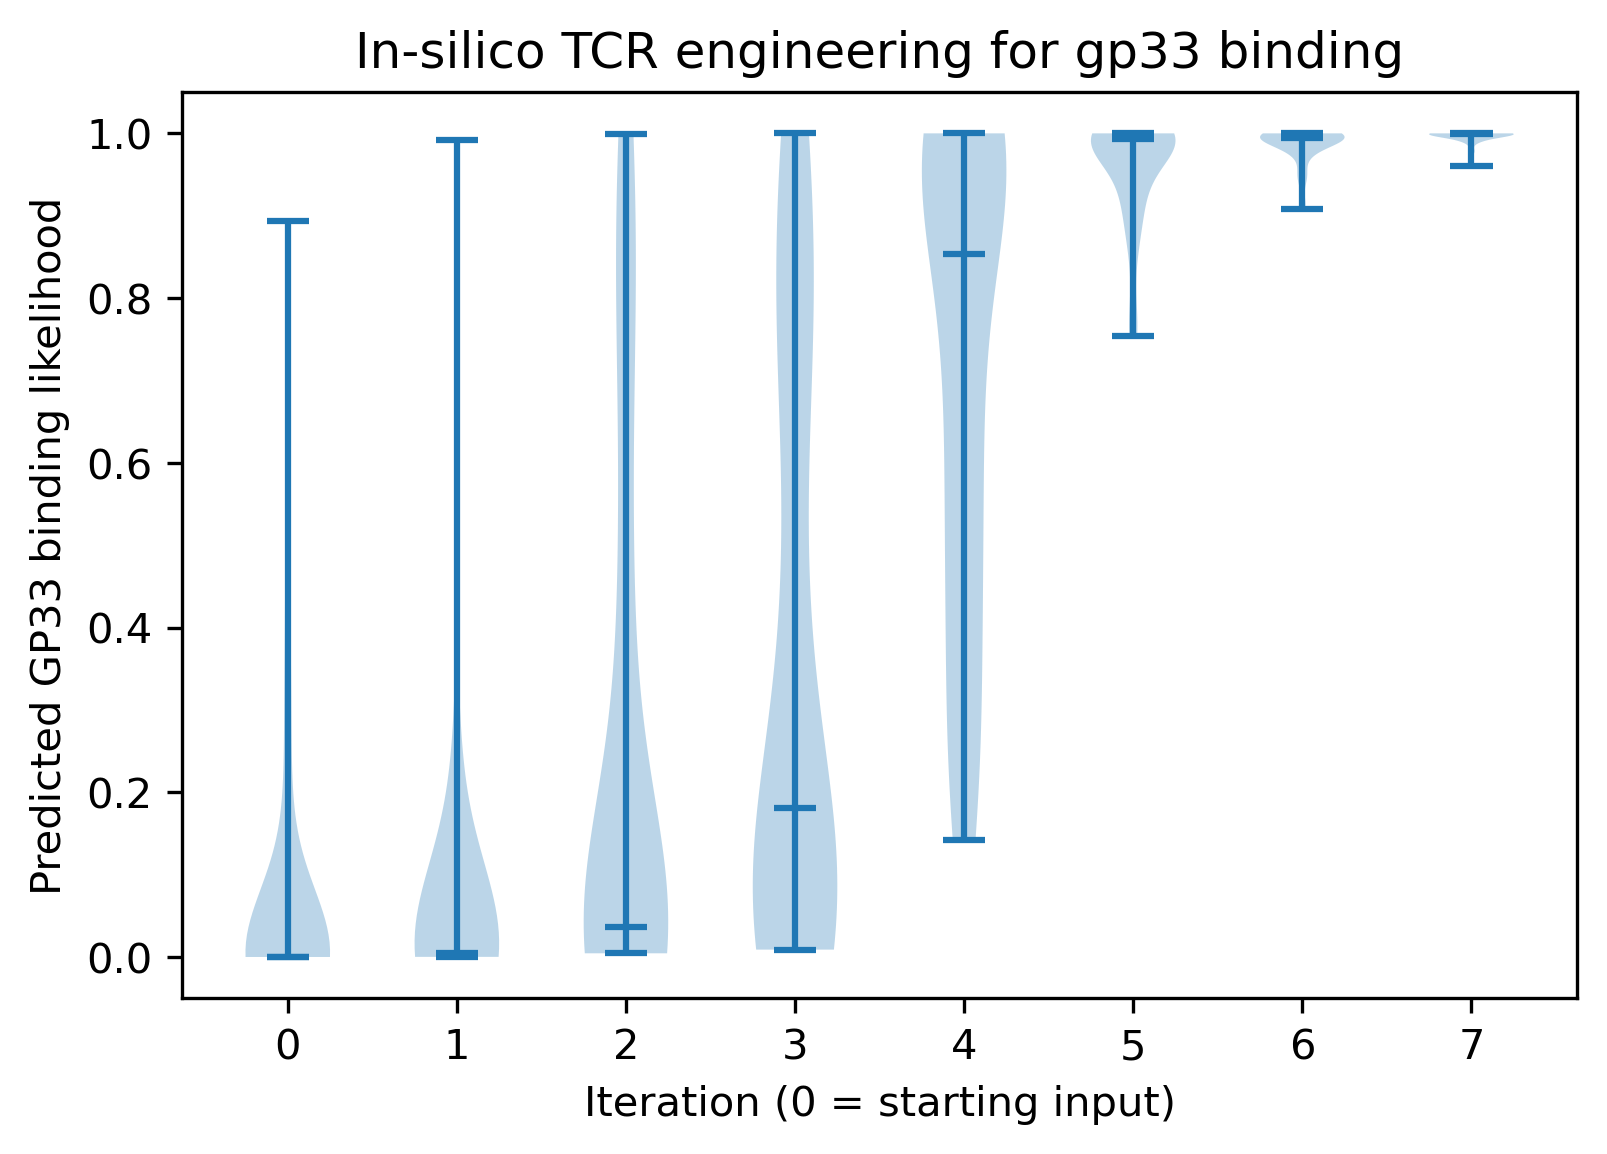

In [15]:
# Plot how the predicting GP33 binding changes over iterations

fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_pvalues.T, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True
)
ax.set(
    xlabel='Iteration (0 = starting input)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel=f"Predicted GP33 binding likelihood",
    title="In-silico TCR engineering for gp33 binding",
)
fig.savefig(os.path.join(PLOT_DIR, "pred_gp33_affinity_iters.pdf"), bbox_inches='tight')
fig.show()

In [16]:
np.all(per_iteration_pvalues[-1] >= 0.9)

True

We see that over iterations, we are generating sequences that are predicted to be have higher and higher likelihood of binding to GP33. However, it is worth asking where these generating sequences are coming from. Namely, are we simply repeating sequences that were already seen before in training? If this were the case, our generation process wouldn't be very useful, since we could simply look back at the training data instead of doing this generation process. 

To check this, we plot the similarity (via edit distance) to any known positive example at each iteration (below). Fortunately, we see that the edit distance does not collapse to 0 at any point, which indicates we are generate sequences that are _different_ from those the model has seen before. 

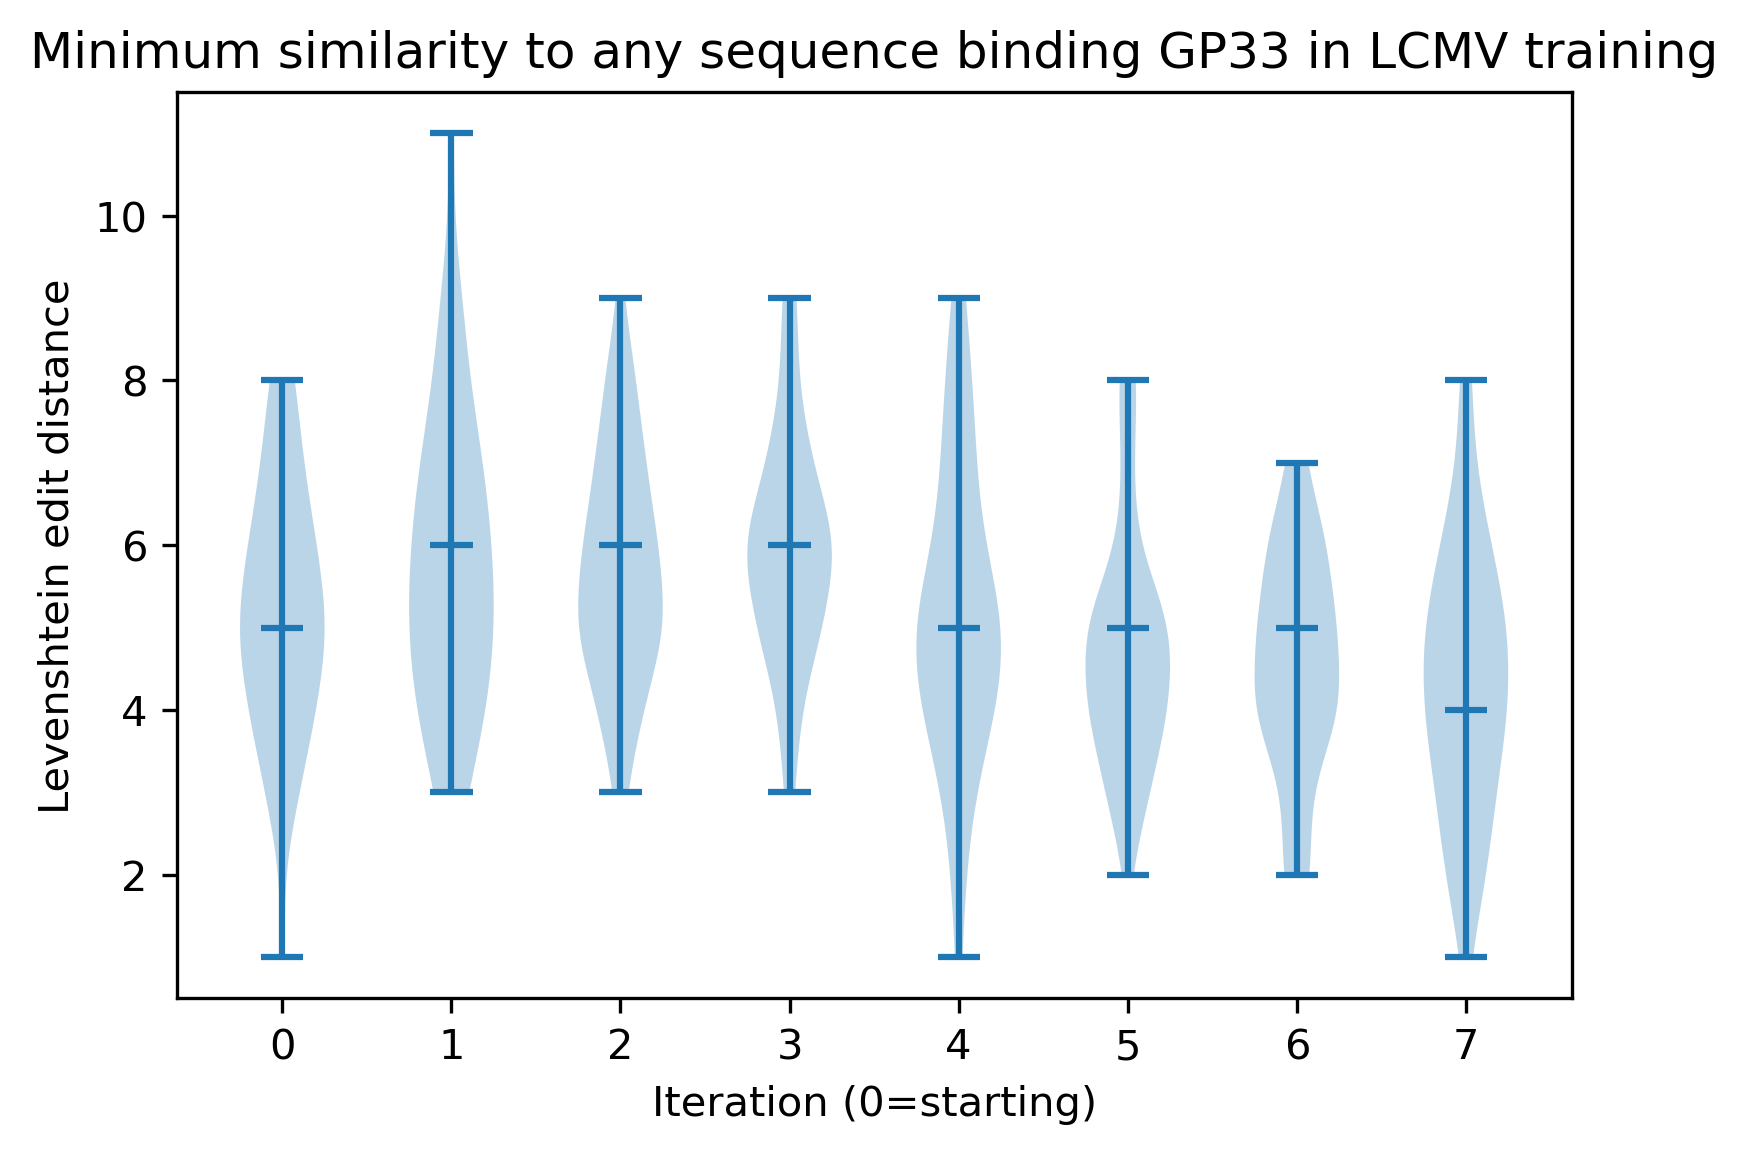

In [17]:
per_iteration_edit_distances = [[tra_trb_dist(p) for p in seq_set] for seq_set in per_iteration_best_seqs]

fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_edit_distances, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True,
)
ax.set(
    xlabel='Iteration (0=starting)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel="Levenshtein edit distance",
    title="Minimum similarity to any sequence binding GP33 in LCMV training"
)
fig.savefig(os.path.join(PLOT_DIR, "similarity_known_binding_iters.pdf"), bbox_inches='tight')
fig.show()

Now that we have checked that the sequences we are generating are novel, and not just repeats of training data, we want to know whether or not these novel sequences are potentially true binders of GP33. For this, we use BLAST to match our generated TRBs (TRAs not evaluated due to insufficient pre-existing data) against known murine TRBs.

In [18]:
eval_cutoff = 0.001
blastp_hits = entrez_utils.run_blast(
    [trb for tra, trb in per_iteration_best_seqs[-1]],
    db=entrez_utils.MOUSE_TRB_BLASTDB,
    e_val=eval_cutoff,
)
blastp_hits

INFO:root:Running BLAST with E-value of 0.001 under: /tmp/tmprz2azyz9
INFO:root:Fetching addtl information for 400 matches


,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,AFR46461,78.571,14,3,0,1,14,10,23,0.000184,27.3,CASGPARANTEVFF,CASSPGQANTEVFF,The LCMV gp33-specific memory T cell repertoir...
1,query-0,AFR46314,78.571,14,3,0,1,14,10,23,0.000184,27.3,CASGPARANTEVFF,CASSPGQANTEVFF,The LCMV gp33-specific memory T cell repertoir...
2,query-0,1208369E,78.571,14,3,0,1,14,1,14,0.000710,26.2,CASGPARANTEVFF,CASSPGGANTEVFF,Alternative splicing of murine T-cell receptor...
3,query-0,AAA58766,78.571,14,3,0,1,14,23,36,0.000800,25.8,CASGPARANTEVFF,CASGARQANTEVFF,Structure-function relationships among highly ...
4,query-0,AFR46260,78.571,14,3,0,1,14,10,23,0.000898,25.4,CASGPARANTEVFF,CASSDARENTEVFF,The LCMV gp33-specific memory T cell repertoir...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,query-49,AFR46285,78.571,14,3,0,1,14,10,23,0.000483,26.2,CASSDWGGNTEVFF,CASRDRGTNTEVFF,The LCMV gp33-specific memory T cell repertoir...
396,query-49,AAB97225,78.571,14,3,0,1,14,1,14,0.000538,26.2,CASSDWGGNTEVFF,CASSQEGANTEVFF,Vbeta4(+) T cells promote clearance of infecti...
397,query-49,AFV60329,71.429,14,4,0,1,14,11,24,0.000548,26.6,CASSDWGGNTEVFF,CASGDWGGHAEQFF,Conservation of Pathogenic TCR Homology across...
398,query-49,AAB97256,78.571,14,3,0,1,14,1,14,0.000661,25.8,CASSDWGGNTEVFF,CASSQPGPNTEVFF,Vbeta4(+) T cells promote clearance of infecti...


In [19]:
start_blastp_hits = entrez_utils.run_blast(
    [trb for tra, trb in per_iteration_best_seqs[0]],
    db=entrez_utils.MOUSE_TRB_BLASTDB,
    e_val=eval_cutoff,
)
start_blastp_hits

INFO:root:Running BLAST with E-value of 0.001 under: /tmp/tmpolgq9af6
INFO:root:Fetching addtl information for 355 matches


,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,ACH87230,84.615,13,2,0,1,13,24,36,0.000562,26.2,CASSPSNNQAPLF,CASRDSNNQAPLF,Persistence of lung CD8 T cell oligoclonal exp...
1,query-1,ADD98514,84.615,13,2,0,1,13,21,33,0.000260,26.9,CAWSLDNTGQLYF,CASSRDNTGQLYF,Toxin-coupled MHC class I tetramers can specif...
2,query-2,ACH87298,92.308,13,1,0,1,13,24,36,0.000055,28.5,CASSLLGEDTQYF,CASSLWGEDTQYF,Persistence of lung CD8 T cell oligoclonal exp...
3,query-2,AFR46479,84.615,13,2,0,1,13,10,22,0.000094,27.7,CASSLLGEDTQYF,CASSLFGQDTQYF,The LCMV gp33-specific memory T cell repertoir...
4,query-2,ACH87266,84.615,13,2,0,1,13,24,36,0.000250,26.9,CASSLLGEDTQYF,CASSLLNQDTQYF,Persistence of lung CD8 T cell oligoclonal exp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,query-48,AAB62342,73.333,15,4,0,1,15,1,15,0.000706,25.8,CASSDSGAGTGQLYF,CASGDPGEDTGQLYF,Spectratyping of TCRs expressed by CTL-infiltr...
351,query-48,ADD98452,73.333,15,4,0,1,15,21,35,0.000865,25.8,CASSDSGAGTGQLYF,CASSRQGENTGQLYF,Toxin-coupled MHC class I tetramers can specif...
352,query-49,AAC14171,84.615,13,2,0,1,13,217,229,0.000362,27.7,CASSDWEQDTQYF,CASRDWAQDTQYF,The cytotoxic T lymphocyte response to the her...
353,query-49,AAC14173,84.615,13,2,0,1,13,18,30,0.000657,26.9,CASSDWEQDTQYF,CASRDWGQDTQYF,The cytotoxic T lymphocyte response to the her...


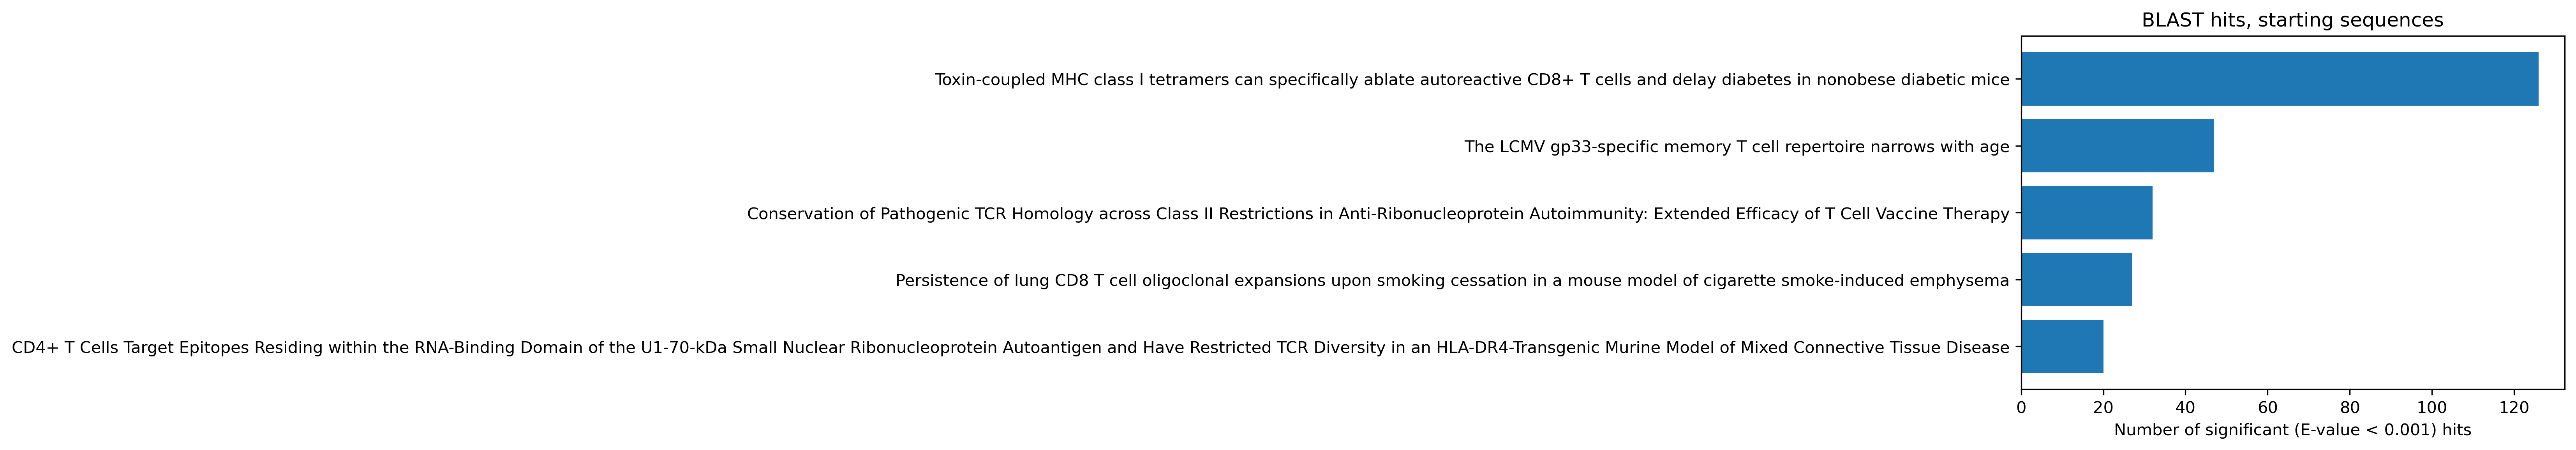

In [20]:
start_hit_titles_cnt = collections.Counter(start_blastp_hits['ms_title'])
fig, ax = plt.subplots(dpi=300)
ax.barh(np.arange(5), [v for _k, v in start_hit_titles_cnt.most_common(5)][::-1])
ax.set_yticks(np.arange(5))
ax.set_yticklabels(
    [k for k, _v in start_hit_titles_cnt.most_common(5)][::-1]
)
ax.set(
    xlabel=f"Number of significant (E-value < {eval_cutoff}) hits",
    title="BLAST hits, starting sequences",
)
fig.savefig(os.path.join(PLOT_DIR, "blast_hit_titles_starting.pdf"), bbox_inches="tight")
fig.show()

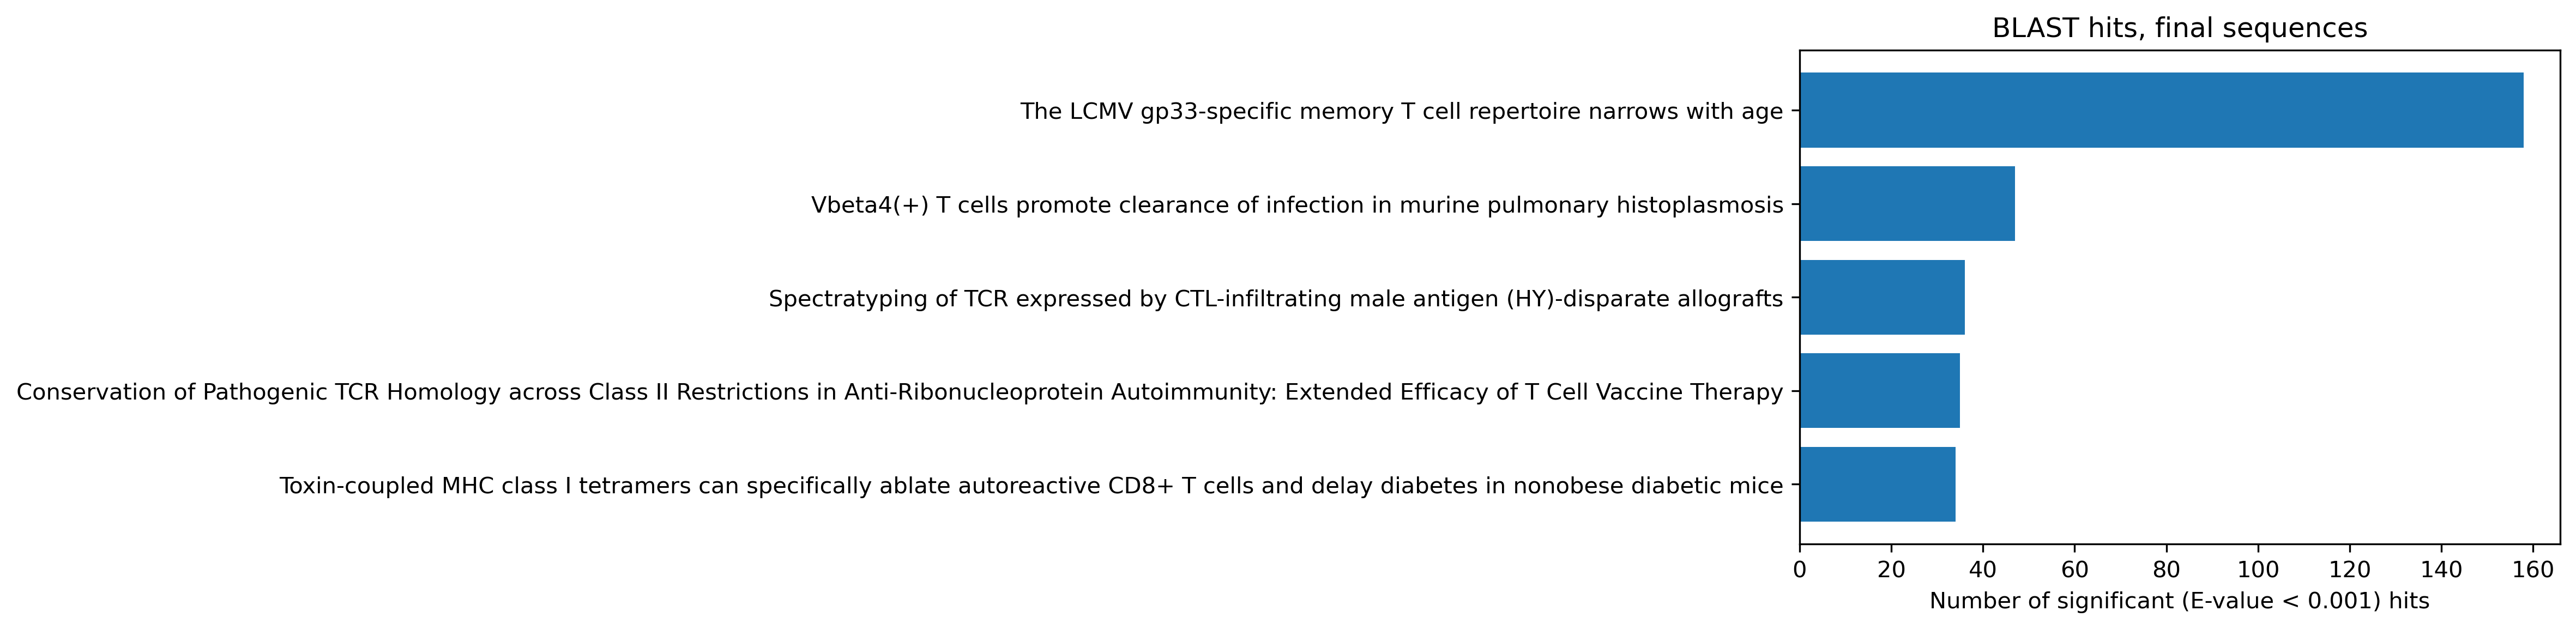

In [21]:
hit_titles_cnt = collections.Counter(blastp_hits['ms_title'])
fig, ax = plt.subplots(dpi=300)
ax.barh(np.arange(5), [v for _k, v in hit_titles_cnt.most_common(5)][::-1])
ax.set_yticks(np.arange(5))
ax.set_yticklabels(
    [k for k, _v in hit_titles_cnt.most_common(5)][::-1]
)
ax.set(
    xlabel=f"Number of significant (E-value < {eval_cutoff}) hits",
    title="BLAST hits, final sequences",
)
fig.savefig(os.path.join(PLOT_DIR, "blast_hit_titles_final.pdf"), bbox_inches="tight")
fig.show()

In [22]:
# Test whether this difference is significant
start_non_gp33_count = np.sum([start_hit_titles_cnt[k] for k in start_hit_titles_cnt if 'gp33' not in k])
start_gp33_count = np.sum([start_hit_titles_cnt[k] for k in start_hit_titles_cnt if 'gp33' in k])

final_non_gp33_count = np.sum([hit_titles_cnt[k] for k in hit_titles_cnt if 'gp33' not in k])
final_gp33_count = np.sum([hit_titles_cnt[k] for k in hit_titles_cnt if 'gp33' in k])

chisquare_count_input = np.array(
    [
        [start_non_gp33_count, start_gp33_count],
        [final_non_gp33_count, final_gp33_count],
    ]
)
print(chisquare_count_input)
scipy.stats.fisher_exact(chisquare_count_input)

[[308  47]
 [242 158]]


(4.27852998065764, 1.759739913362712e-16)

After BLAST-ing our starting and final sequences, we find that the final set of engineered sequences specifically and significantly enriches for independently-identified TRBs binding to GP33. It is worth re-iterating that these matches are to a set of GP33-binding TRBs that was never shown to TCR-BERT, and was profiled independently from all work we did to train TCR-BERT. Thus, the fact that TCR-BERT generates TCRs that match these previously identified sequences shows that TCR-BERT has learned a fairly general understanding of the types of TCRs that GP33, and that our method for TCR engineering can successfully probe this learned understanding to extract novel sequences.

To help visualize these similarities, we create motif logos to illustrate:
* The generated sequences with significant similarity to independently-identified GP33 binders
* Those independently-identified GP33 binders

In [23]:
blastp_gp33_hits = pd.DataFrame(
    [row for i, row in blastp_hits.iterrows() if 'gp33' in row['ms_title']]
)
blastp_gp33_hits

,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,AFR46461,78.571,14,3,0,1,14,10,23,0.000184,27.3,CASGPARANTEVFF,CASSPGQANTEVFF,The LCMV gp33-specific memory T cell repertoir...
1,query-0,AFR46314,78.571,14,3,0,1,14,10,23,0.000184,27.3,CASGPARANTEVFF,CASSPGQANTEVFF,The LCMV gp33-specific memory T cell repertoir...
4,query-0,AFR46260,78.571,14,3,0,1,14,10,23,0.000898,25.4,CASGPARANTEVFF,CASSDARENTEVFF,The LCMV gp33-specific memory T cell repertoir...
5,query-1,AFR46373,92.857,14,1,0,1,14,10,23,0.000022,29.6,CASSDAGLNTEVFF,CASSDAGANTEVFF,The LCMV gp33-specific memory T cell repertoir...
6,query-1,AFR46211,92.857,14,1,0,1,14,10,23,0.000022,29.6,CASSDAGLNTEVFF,CASSDAGANTEVFF,The LCMV gp33-specific memory T cell repertoir...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,query-49,AFR46373,85.714,14,2,0,1,14,10,23,0.000097,27.7,CASSDWGGNTEVFF,CASSDAGANTEVFF,The LCMV gp33-specific memory T cell repertoir...
388,query-49,AFR46211,85.714,14,2,0,1,14,10,23,0.000097,27.7,CASSDWGGNTEVFF,CASSDAGANTEVFF,The LCMV gp33-specific memory T cell repertoir...
392,query-49,AFR46387,92.857,14,0,1,1,14,10,22,0.000268,26.9,CASSDWGGNTEVFF,CASSDWGNTEVFF,The LCMV gp33-specific memory T cell repertoir...
394,query-49,AFR46295,71.429,14,4,0,1,14,10,23,0.000483,26.2,CASSDWGGNTEVFF,CASSEWGGDAEQFF,The LCMV gp33-specific memory T cell repertoir...


In [24]:
blastp_start_gp33_hits = pd.DataFrame(
    [row for i, row in start_blastp_hits.iterrows() if 'gp33' in row['ms_title']]
)
blastp_start_gp33_hits

,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
3,query-2,AFR46479,84.615,13,2,0,1,13,10,22,0.000094,27.7,CASSLLGEDTQYF,CASSLFGQDTQYF,The LCMV gp33-specific memory T cell repertoir...
7,query-2,AFR46427,84.615,13,2,0,1,13,10,22,0.001000,25.4,CASSLLGEDTQYF,CASSLRREDTQYF,The LCMV gp33-specific memory T cell repertoir...
8,query-2,AFR46351,84.615,13,2,0,1,13,10,22,0.001000,25.4,CASSLLGEDTQYF,CASSDRGEDTQYF,The LCMV gp33-specific memory T cell repertoir...
10,query-2,AFR46481,84.615,13,2,0,1,13,10,22,0.001000,25.4,CASSLLGEDTQYF,CASSLLLKDTQYF,The LCMV gp33-specific memory T cell repertoir...
22,query-9,AFR46271,80.000,15,3,0,1,15,10,24,0.000150,27.3,CASSLEQGGAETLYF,CASSLDWGSAETLYF,The LCMV gp33-specific memory T cell repertoir...
29,query-10,AFR46493,84.615,13,2,0,1,13,10,22,0.000319,26.6,CASSLGGYAEQFF,CASSITGYAEQFF,The LCMV gp33-specific memory T cell repertoir...
49,query-12,AFR46419,78.571,14,3,0,1,14,10,23,0.000341,26.6,CASSETVSGNTLYF,CASSSEISGNTLYF,The LCMV gp33-specific memory T cell repertoir...
60,query-14,AFR46296,87.500,16,0,1,1,14,10,25,0.000125,27.7,CASSLGGNQDTQYF,CASSLATGGNQDTQYF,The LCMV gp33-specific memory T cell repertoir...
63,query-14,AFR46230,85.714,14,2,0,1,14,10,23,0.000238,26.9,CASSLGGNQDTQYF,CASSLTINQDTQYF,The LCMV gp33-specific memory T cell repertoir...
67,query-14,AFR46229,85.714,14,2,0,1,14,10,23,0.000313,26.6,CASSLGGNQDTQYF,CASSLLGGQDTQYF,The LCMV gp33-specific memory T cell repertoir...


In [25]:
# 
np.mean(blastp_start_gp33_hits['bit_score']), np.mean(blastp_gp33_hits['bit_score'])

(26.674468085106383, 27.406329113924045)

In [26]:
# Comapre all bit scores from all GP33 matches
bitscore_stat, bitscore_pval = scipy.stats.mannwhitneyu(
    blastp_gp33_hits['bit_score'],
    blastp_start_gp33_hits['bit_score'],
)
bitscore_stat, bitscore_pval

(2779.0, 0.00430612444385852)

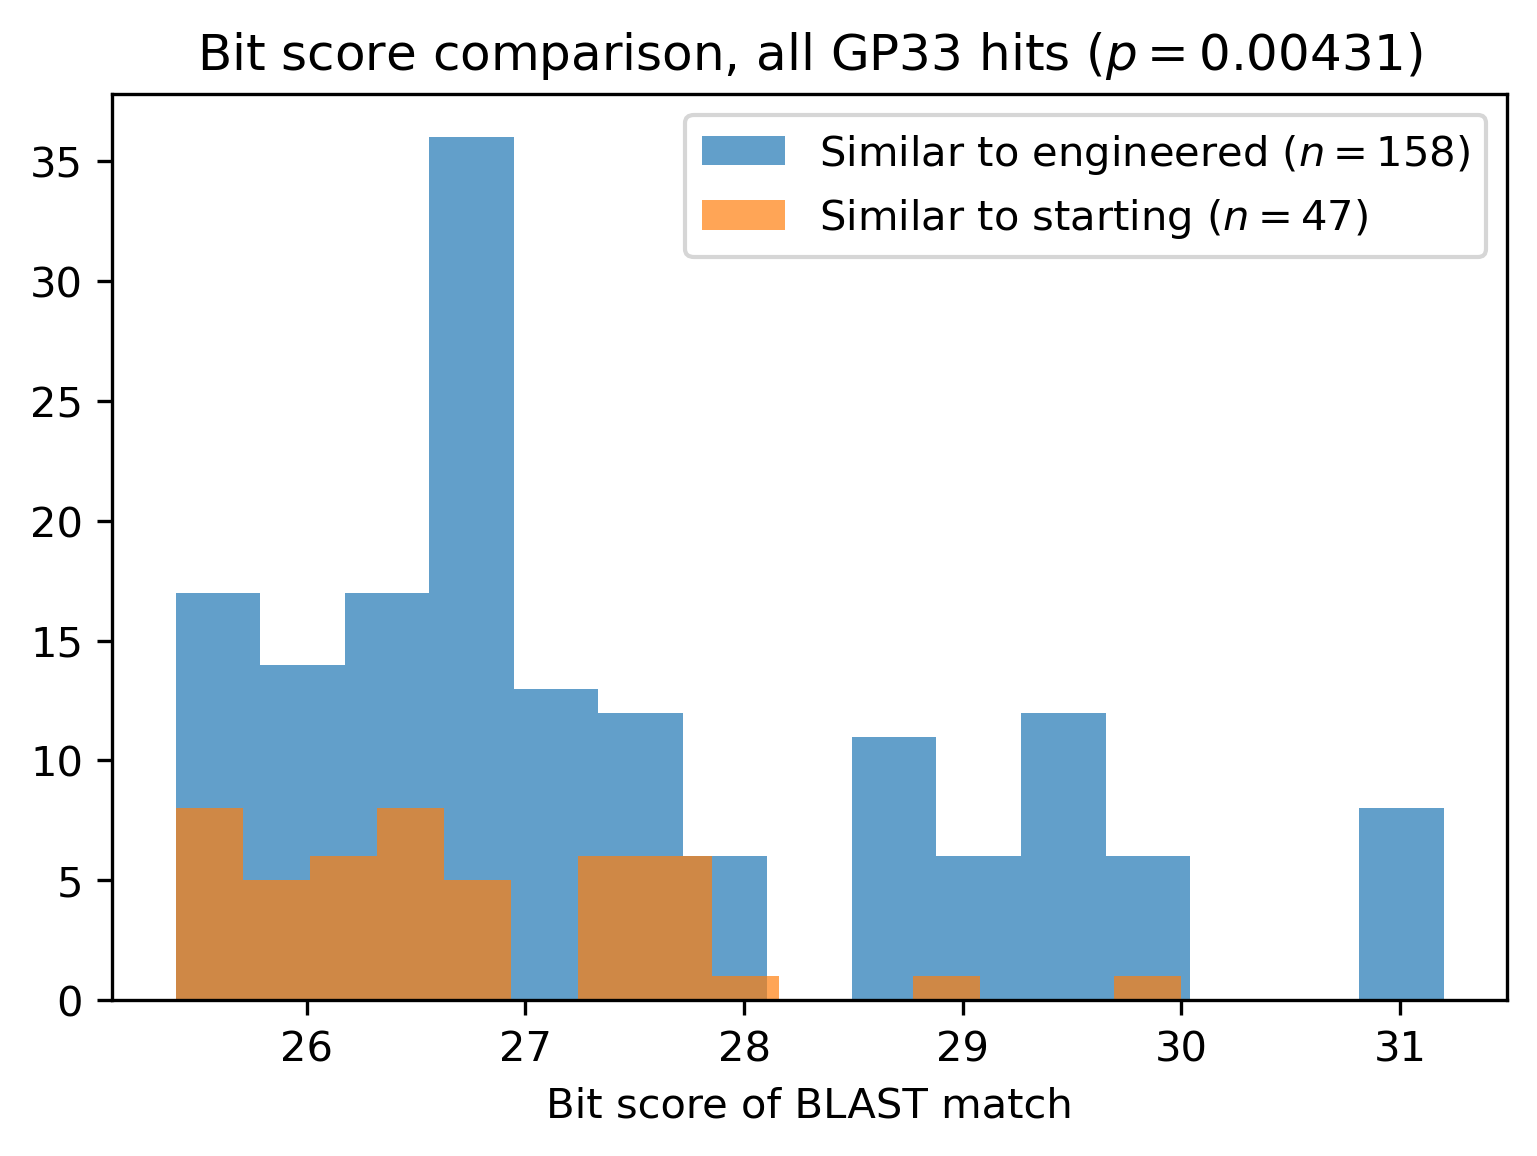

In [27]:
fig, ax = plt.subplots(dpi=300)
ax.hist(
    blastp_gp33_hits['bit_score'], label=f'Similar to engineered ($n={len(blastp_gp33_hits)}$)',
    bins=15, alpha=0.7
)
ax.hist(
    blastp_start_gp33_hits['bit_score'], label=f'Similar to starting ($n={len(blastp_start_gp33_hits)}$)',
    bins=15, alpha=0.7
)
ax.legend()
ax.set(
    xlabel="Bit score of BLAST match",
    title=f"Bit score comparison, all GP33 hits ($p={bitscore_pval:.3g}$)",
)
fig.savefig(os.path.join(PLOT_DIR, "bitscore_comparison_hist.pdf"), bbox_inches='tight')
fig.show()

In [28]:
# The set of the highest bit scores correspond to a TRB that was also
# matched in the starting set, but these are high bit scores
set(
    blastp_gp33_hits.iloc[np.where(blastp_gp33_hits['bit_score'] > 30.5)]['subject_seq']
)

{'CASSDAGANTEVFF'}

The following are the starting sequences in the following order:

* All starting sequences
* Starting sequences that match a GP33 sequence
* Those prior known GP33 binders

INFO:root:Running MUSCLE for MSA in /tmp/tmp4ljdb4hj


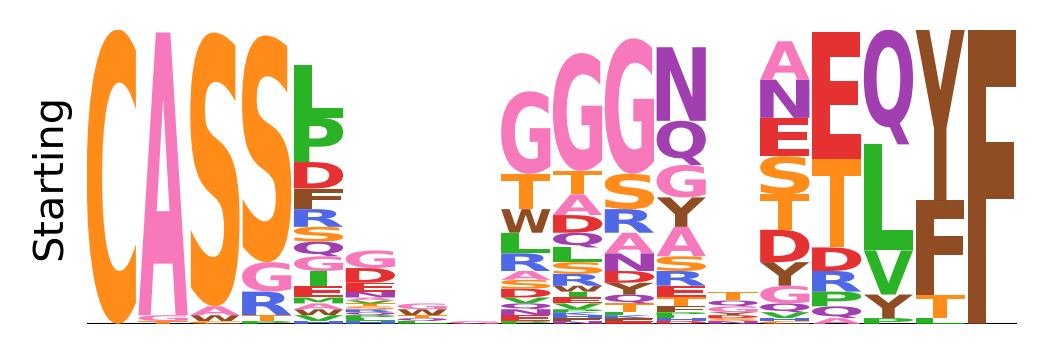

In [29]:
# Starting
importlib.reload(custom_metrics)
logo_kwargs = {
    "color_scheme": "dmslogo_funcgroup",
    "normalize_pwm": False,
    "show_spines": False,
    "alpha": 0.9,
}

fig, ax = plt.subplots(figsize=(4, 1.3), dpi=300)
custom_metrics.motif_from_sequences(
    [s[1] for s in sequences], ax=ax, **logo_kwargs,
)[1]
ax.set(
    xticks=[], yticks=[], ylabel='Starting',
)
fig.savefig(os.path.join(PLOT_DIR, "starting_logo.pdf"), bbox_inches='tight')
fig.show()

INFO:root:Running MUSCLE for MSA in /tmp/tmpenz7akgl


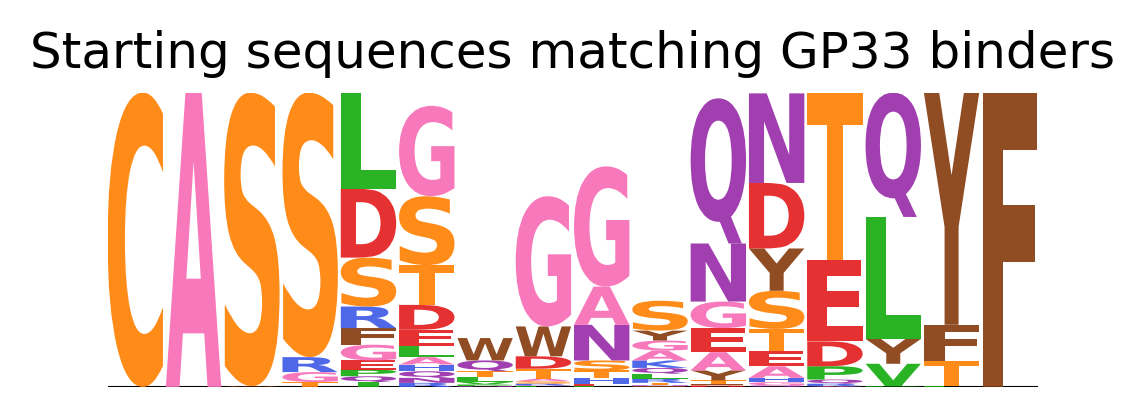

In [30]:
# Starting matches
importlib.reload(custom_metrics)

fig, ax = plt.subplots(figsize=(4, 1.3), dpi=300)
custom_metrics.motif_from_sequences(
    list(start_blastp_hits['query_seq']), ax=ax, **logo_kwargs,
)[1]
ax.set(
    xticks=[],
    yticks=[],
    title="Starting sequences matching GP33 binders",
)
fig.savefig(os.path.join(PLOT_DIR, "starting_matches_ours_logo.pdf"), bbox_inches='tight')
fig.show()

INFO:root:Running MUSCLE for MSA in /tmp/tmpg5_zakzj


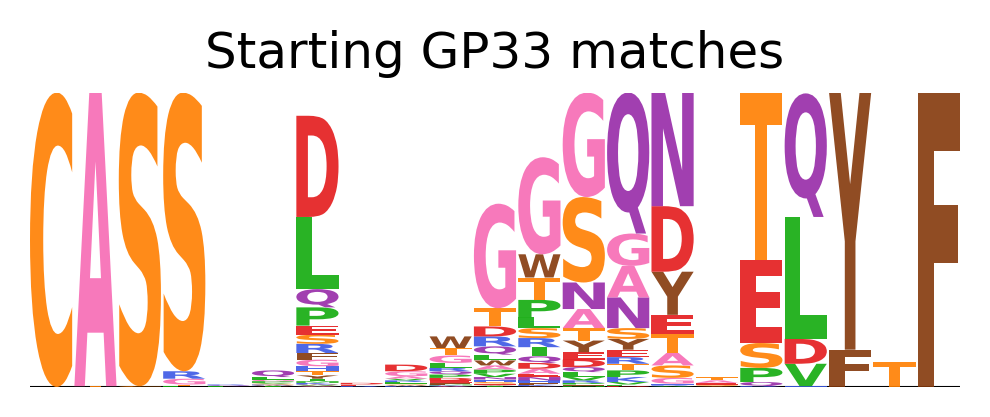

In [31]:
# Starting database matches

importlib.reload(custom_metrics)
fig, ax = plt.subplots(figsize=(4, 1.3), dpi=300)
custom_metrics.motif_from_sequences(
    list(start_blastp_hits['subject_seq']),
    ax=ax,
    **logo_kwargs,
)[1]
ax.set(
    xticks=[],
    yticks=[],
    title="Starting GP33 matches",
)
fig.savefig(os.path.join(PLOT_DIR, "starting_matches_logo.pdf"), bbox_inches='tight')
fig.show()

INFO:root:Running MUSCLE for MSA in /tmp/tmp3qypuffo


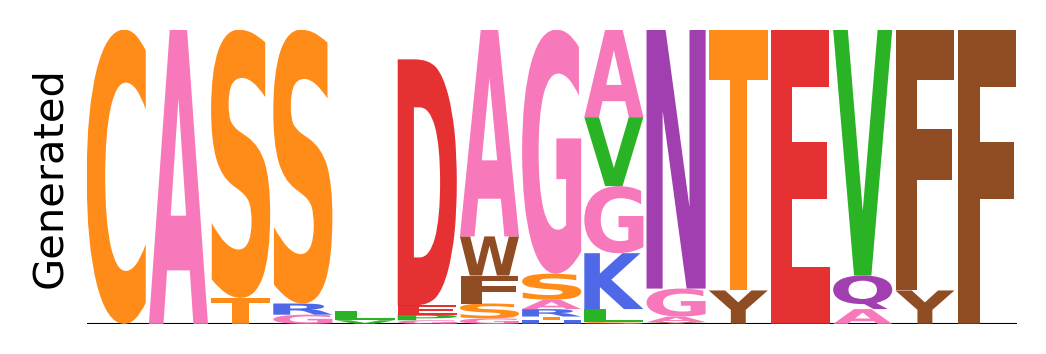

In [32]:
# Generated
importlib.reload(custom_metrics)

fig, ax = plt.subplots(figsize=(4, 1.3), dpi=300)
custom_metrics.motif_from_sequences(
    list(blastp_gp33_hits['query_seq']), ax=ax, **logo_kwargs
)[1]
ax.set(
    xticks=[],
    yticks=[],
    ylabel='Generated'
)
fig.savefig(os.path.join(PLOT_DIR, "generated_logo.pdf"), bbox_inches='tight')
fig.show()

INFO:root:Running MUSCLE for MSA in /tmp/tmp046fh798


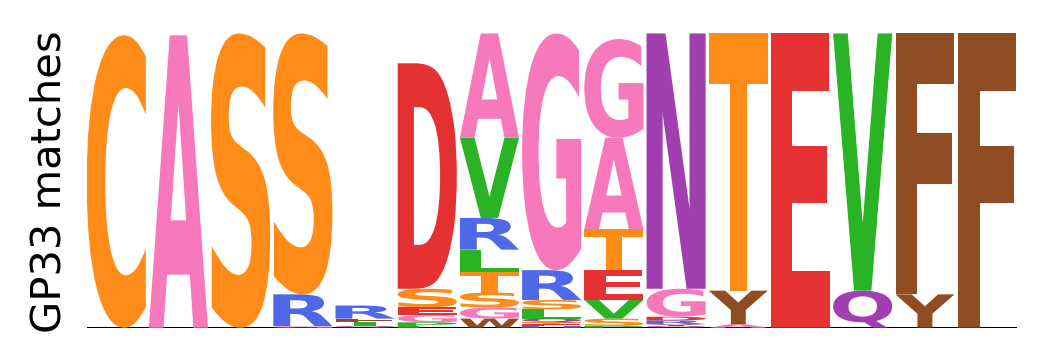

In [33]:
# BLAST matches
importlib.reload(custom_metrics)

fig, ax = plt.subplots(figsize=(4, 1.3), dpi=300)
custom_metrics.motif_from_sequences(
#     [s for s in blastp_gp33_hits['subject_seq'] if len(s) == 14],  # Filter on seq len for cleaner plot
    blastp_gp33_hits['subject_seq'],  # Do not filter in seq len
    ax=ax, **logo_kwargs,
)[1]
ax.set(
    xticks=[], yticks=[], ylabel='GP33 matches',
)
fig.savefig(os.path.join(PLOT_DIR, "blast_matches_logo.pdf"), bbox_inches='tight')
fig.show()

It is clear that we enrich for additional GP33 matches, but are we preserving the same matches as the start set produces (and just hitting them more often) or are we generating sequences that match to additional known sequences?

In [34]:
starting_matching_known = collections.Counter(blastp_start_gp33_hits['subject_seq'])
starting_matching_known.most_common()

[('CASSLDWGSAETLYF', 2),
 ('CASSLLGGQDTQYF', 2),
 ('CASSLGSYNSPLYF', 2),
 ('CASSLLGGYEQYF', 2),
 ('CASSDHTNTEVFF', 2),
 ('CASSLGTGGPYAEQFF', 2),
 ('CASSDAGANTEVFF', 2),
 ('CASSDVGGNTEVFF', 2),
 ('CASSLFGQDTQYF', 1),
 ('CASSLRREDTQYF', 1),
 ('CASSDRGEDTQYF', 1),
 ('CASSLLLKDTQYF', 1),
 ('CASSITGYAEQFF', 1),
 ('CASSSEISGNTLYF', 1),
 ('CASSLATGGNQDTQYF', 1),
 ('CASSLTINQDTQYF', 1),
 ('CASSLVGARDTQYF', 1),
 ('CASSQETGSNTEVFF', 1),
 ('CASSRDSGANTEVFF', 1),
 ('CASSERDNANTEVFF', 1),
 ('CASSQRTGGHEQYF', 1),
 ('CASSLGQYNSPLYF', 1),
 ('CASSEGNYNSPLYF', 1),
 ('CASSIGQNNSPLYF', 1),
 ('CASREQGNYNSPLYF', 1),
 ('CASSQTGDSYNSPLYF', 1),
 ('CASSLDFGGSAETLYF', 1),
 ('CASSLEWGSSAETLYF', 1),
 ('CASSFWGGGQNTLYF', 1),
 ('CASSLGWGQNTLYF', 1),
 ('CASSPWTGGSQNTLYF', 1),
 ('CASSDRTGSSYEQYF', 1),
 ('CASSRQGANSDYTF', 1),
 ('CASSLWSSYEQYF', 1),
 ('CASSFWGGDEQYF', 1),
 ('CASSVGGGYEQYF', 1),
 ('CASSLSTGYEQYF', 1),
 ('CASSPGQGLYAEQFF', 1),
 ('CASSDARENTEVFF', 1)]

In [35]:
final_matching_known = collections.Counter(blastp_gp33_hits['subject_seq'])
final_matching_known

Counter({'CASSPGQANTEVFF': 2,
         'CASSDARENTEVFF': 16,
         'CASSDAGANTEVFF': 40,
         'CASSDVGGNTEVFF': 38,
         'CASRDRGTNTEVFF': 17,
         'CASSSTGVNTEVFF': 10,
         'CASSLLGGYEQYF': 5,
         'CASSVGGGYEQYF': 5,
         'CASSLSTGYEQYF': 5,
         'CASGEGESYTEVFF': 1,
         'CASSRDSGANTEVFF': 6,
         'CASSIGGGSNTEVFF': 2,
         'CASSLGHPNTEVFF': 1,
         'CASSDWGNTEVFF': 3,
         'CASSFGLGGRYEQYF': 2,
         'CASSQETGSNTEVFF': 1,
         'SSRDSGANTEVFF': 1,
         'CASSEWGGDAEQFF': 2,
         'CASSSTGQYEQYF': 1})

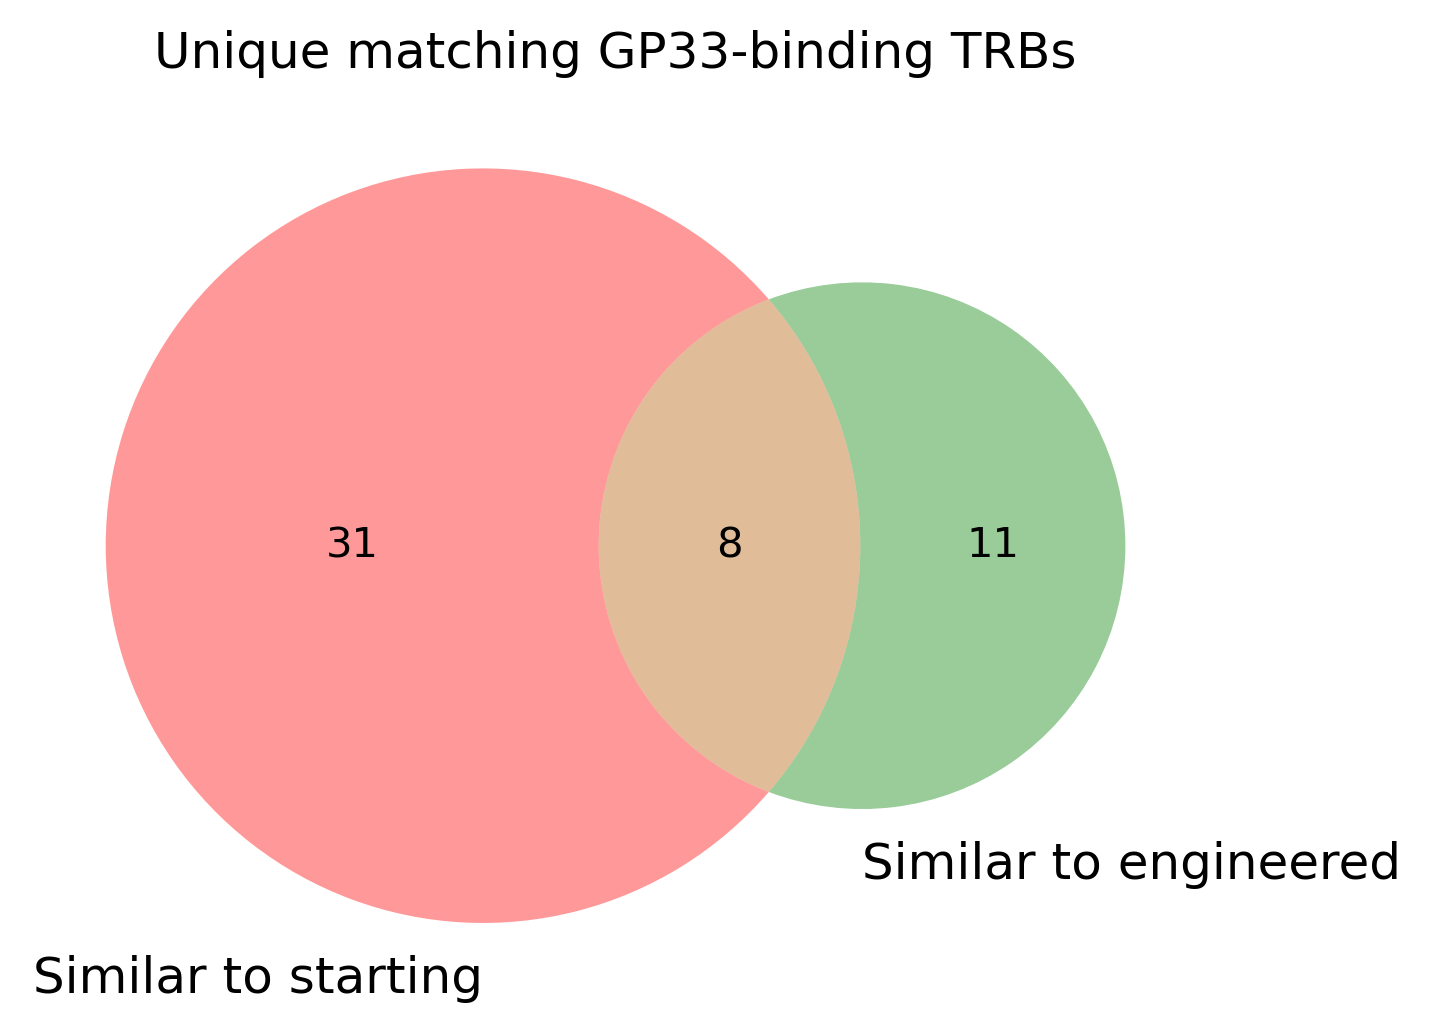

In [36]:
from matplotlib_venn import venn2, venn2_circles

fig, ax = plt.subplots(dpi=300)
venn2(
    [starting_matching_known.keys(), final_matching_known.keys()],
    set_labels=['Similar to starting', 'Similar to engineered'],
    ax=ax,
)
ax.set(
    title="Unique matching GP33-binding TRBs"
)
fig.savefig(os.path.join(PLOT_DIR, "venn_diagram_matches.pdf"), bbox_inches='tight')
fig.show()

#### Novel
We explore the new matches that weren't there in the original starting set

In [37]:
novel_matches = set(final_matching_known) - set(starting_matching_known)
novel_matches_df = blastp_gp33_hits.iloc[
    np.where([seq in novel_matches for seq in blastp_gp33_hits['subject_seq']])
]
novel_matches_df.shape

(42, 15)

INFO:root:Running MUSCLE for MSA in /tmp/tmpm4o61l0z
INFO:root:Running MUSCLE for MSA in /tmp/tmp22235fvn


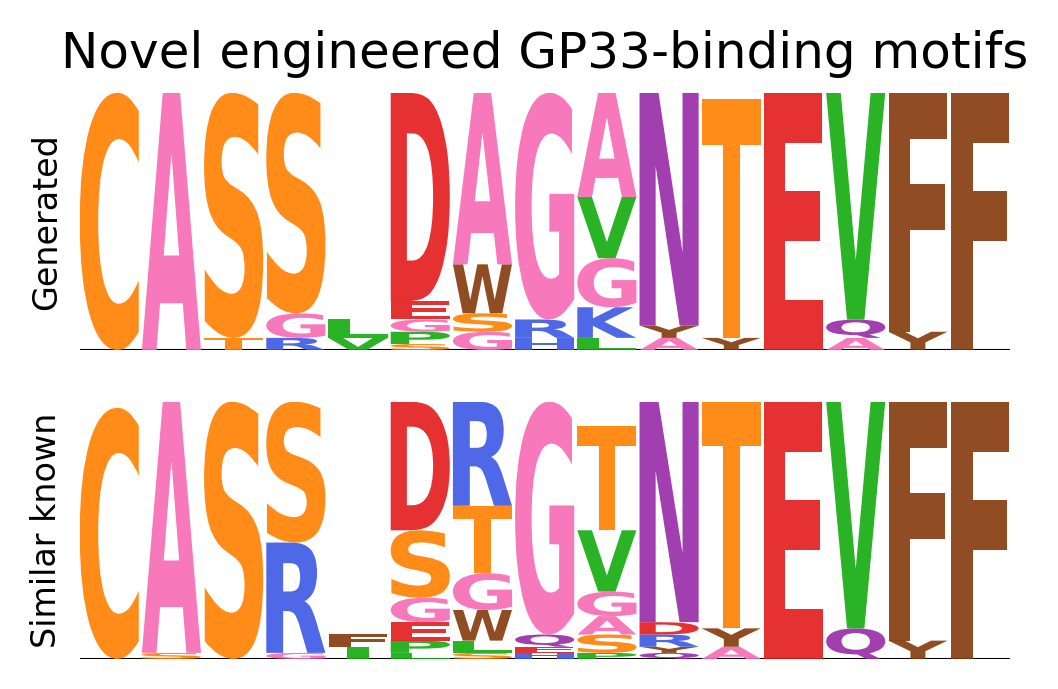

In [38]:
fig, (ax1, ax2) = plt.subplots(figsize=(4, 2.5), dpi=300, nrows=2)

custom_metrics.motif_from_sequences(
    novel_matches_df['query_seq'],
    ax=ax1, **logo_kwargs,
)[1]
ax1.set_ylabel("Generated", size=8)

custom_metrics.motif_from_sequences(
    novel_matches_df['subject_seq'],
    ax=ax2, **logo_kwargs,
)[1]
ax2.set_ylabel("Similar known", size=8)

for ax in (ax1, ax2):
    ax.set(xticks=[], yticks=[])
    
ax1.set_title("Novel engineered GP33-binding motifs")
fig.savefig(os.path.join(PLOT_DIR, "motif_comparison_novel.pdf"), bbox_inches='tight')
fig.show()

INFO:root:Running MUSCLE for MSA in /tmp/tmprkf4b10c
INFO:root:Running MUSCLE for MSA in /tmp/tmp54uavg08


INFO:root:Running MUSCLE for MSA in /tmp/tmprmu0umg5


INFO:root:Running MUSCLE for MSA in /tmp/tmpnnr7omj_


INFO:root:Running MUSCLE for MSA in /tmp/tmpnrtl8_vb
INFO:root:Running MUSCLE for MSA in /tmp/tmpjvik7nt0


INFO:root:Running MUSCLE for MSA in /tmp/tmptbmikrg5


INFO:root:Running MUSCLE for MSA in /tmp/tmp3mjax1jc


INFO:root:Running MUSCLE for MSA in /tmp/tmpjh5nm1az
INFO:root:Running MUSCLE for MSA in /tmp/tmpnvzl7cbk


INFO:root:Running MUSCLE for MSA in /tmp/tmpfs4d86t5
INFO:root:Running MUSCLE for MSA in /tmp/tmp9ijgv17n


INFO:root:Running MUSCLE for MSA in /tmp/tmp8khv40f6
INFO:root:Running MUSCLE for MSA in /tmp/tmpyowz5qoe


INFO:root:Running MUSCLE for MSA in /tmp/tmpl1y3j1f2


INFO:root:Running MUSCLE for MSA in /tmp/tmpur66c4n2


INFO:root:Running MUSCLE for MSA in /tmp/tmp5ie4bout


INFO:root:Running MUSCLE for MSA in /tmp/tmpa4jx1igw


INFO:root:Running MUSCLE for MSA in /tmp/tmpy97gdv_p
INFO:root:Running MUSCLE for MSA in /tmp/tmpd98ss0vh


INFO:root:Running MUSCLE for MSA in /tmp/tmptaf5wzs4
INFO:root:Running MUSCLE for MSA in /tmp/tmpn6lye4ec


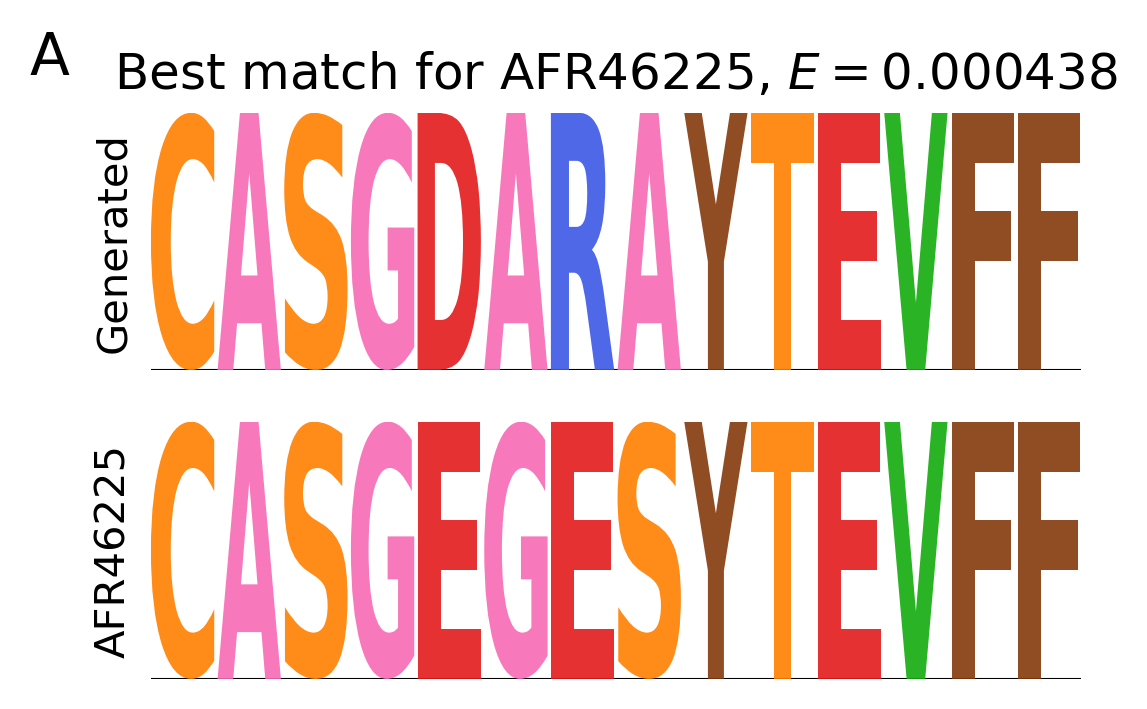

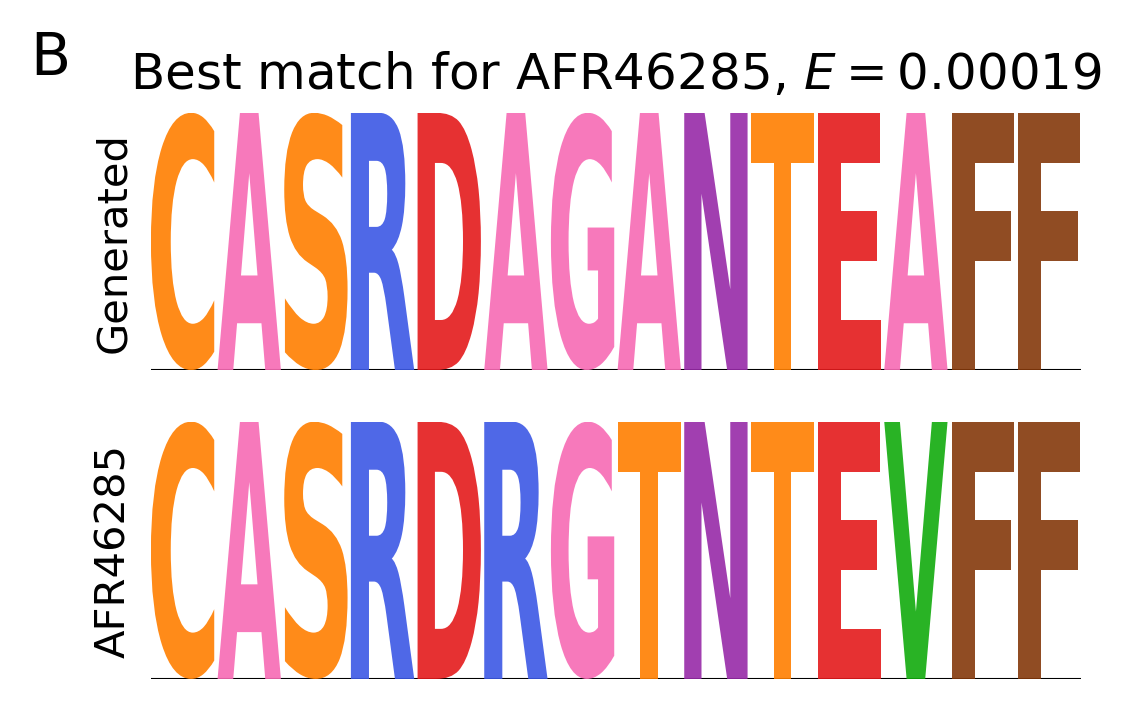

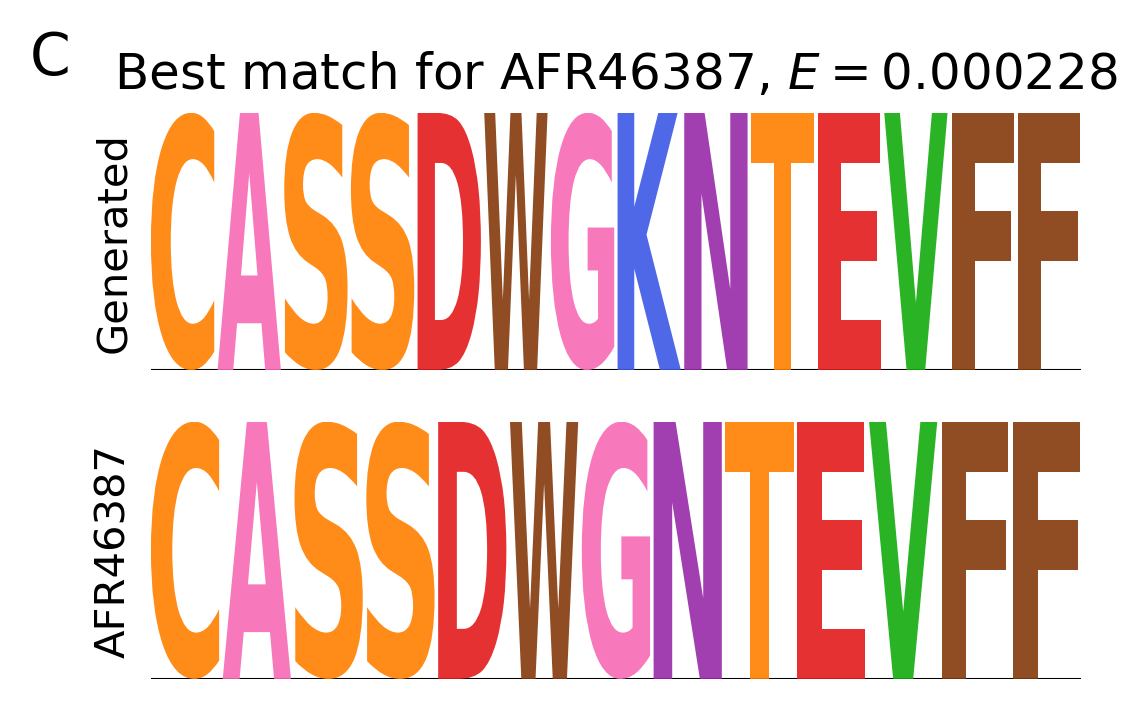

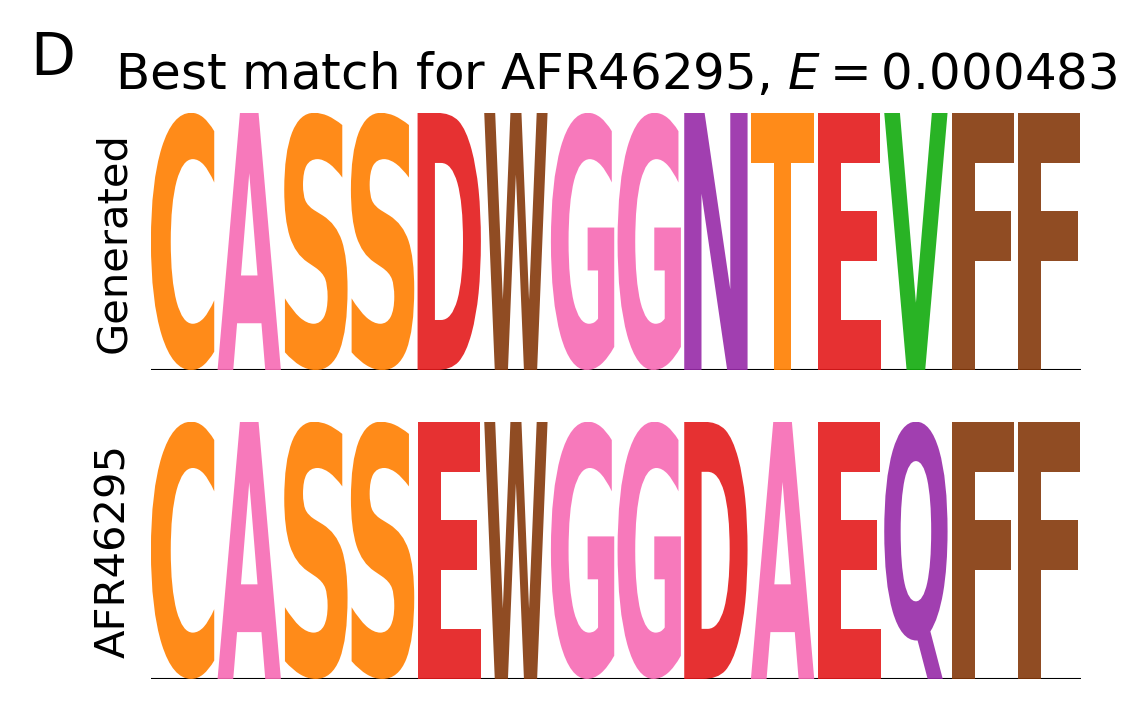

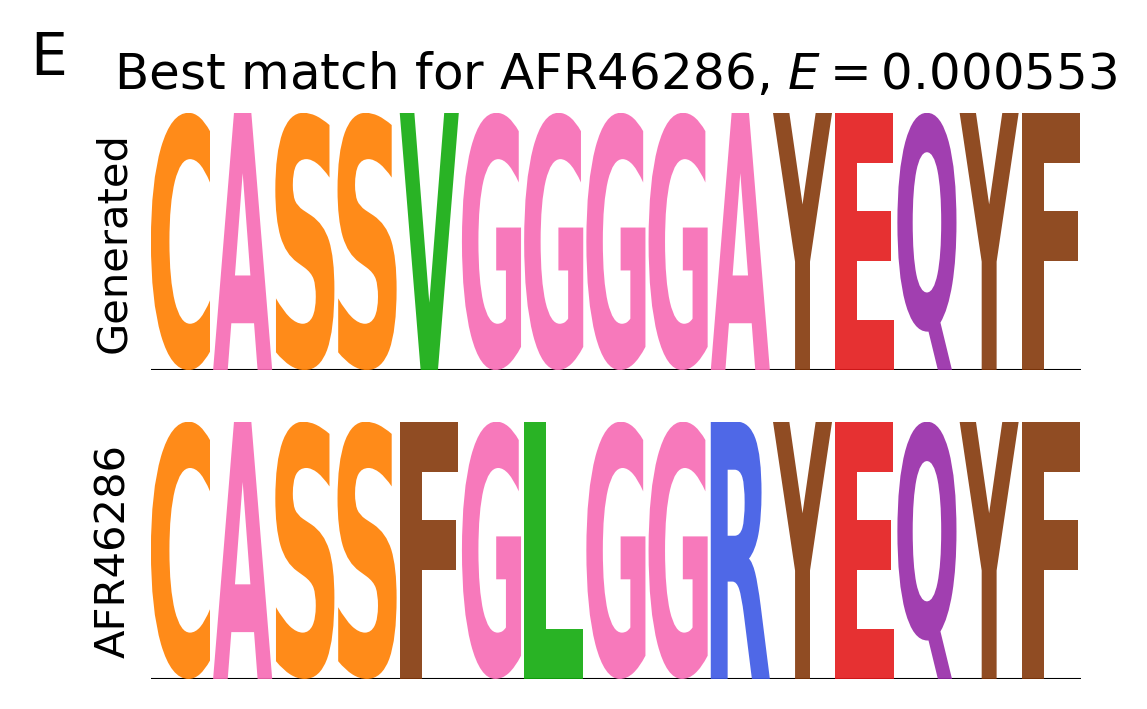

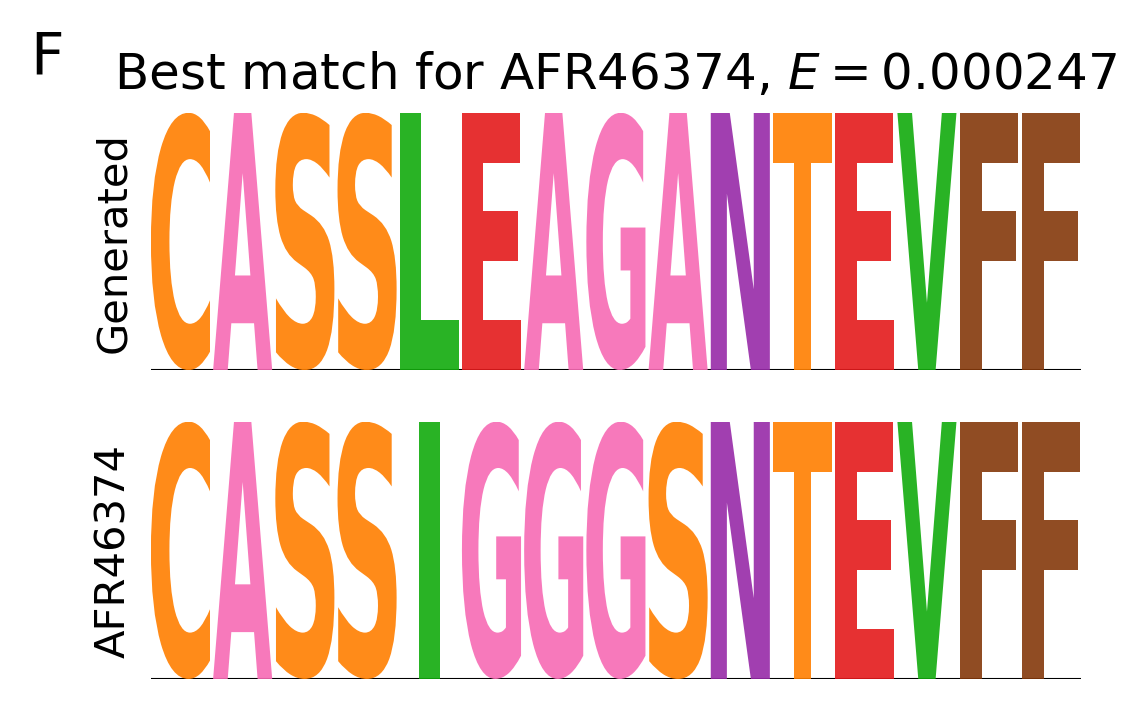

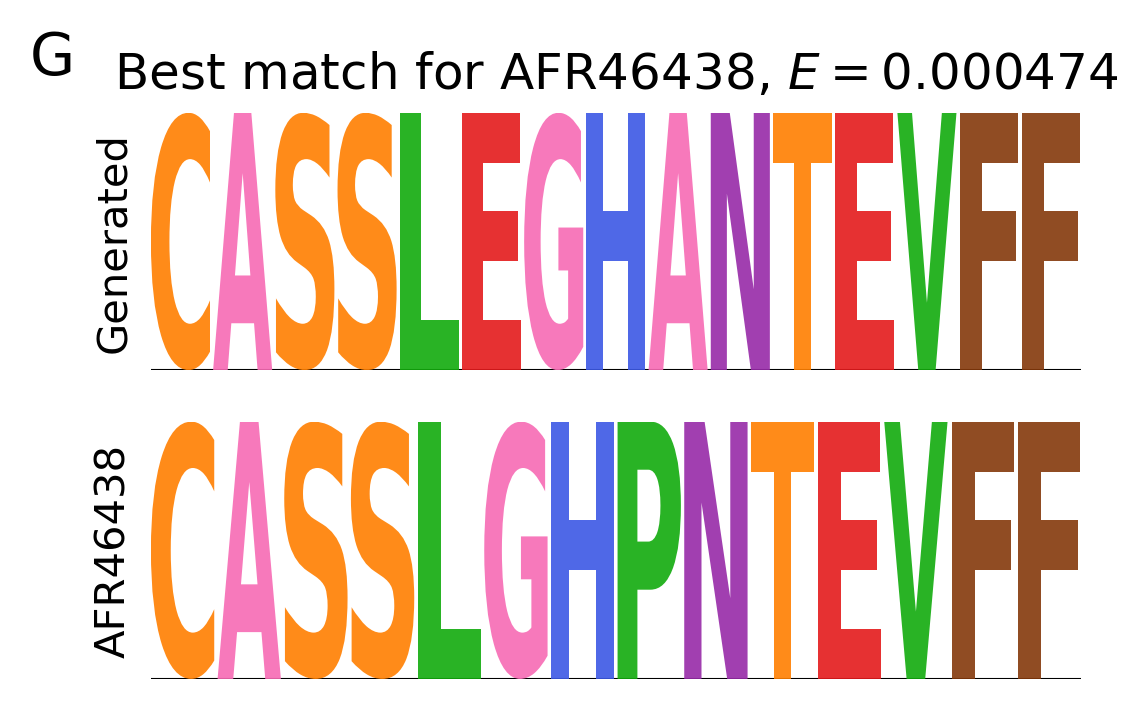

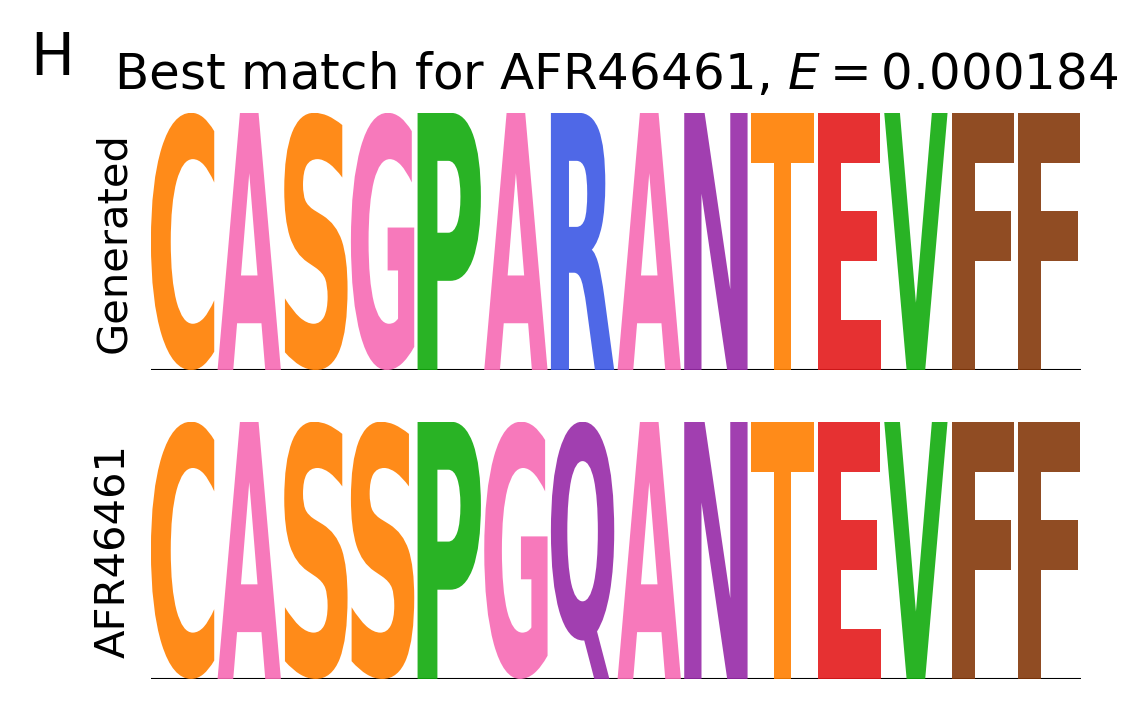

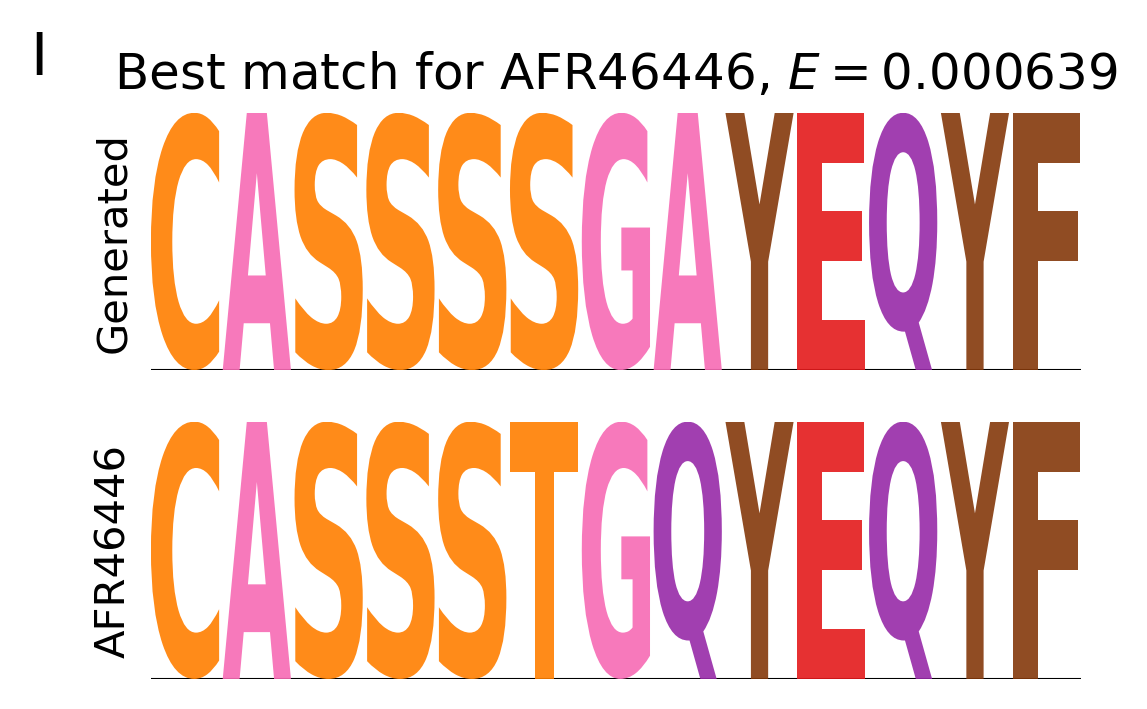

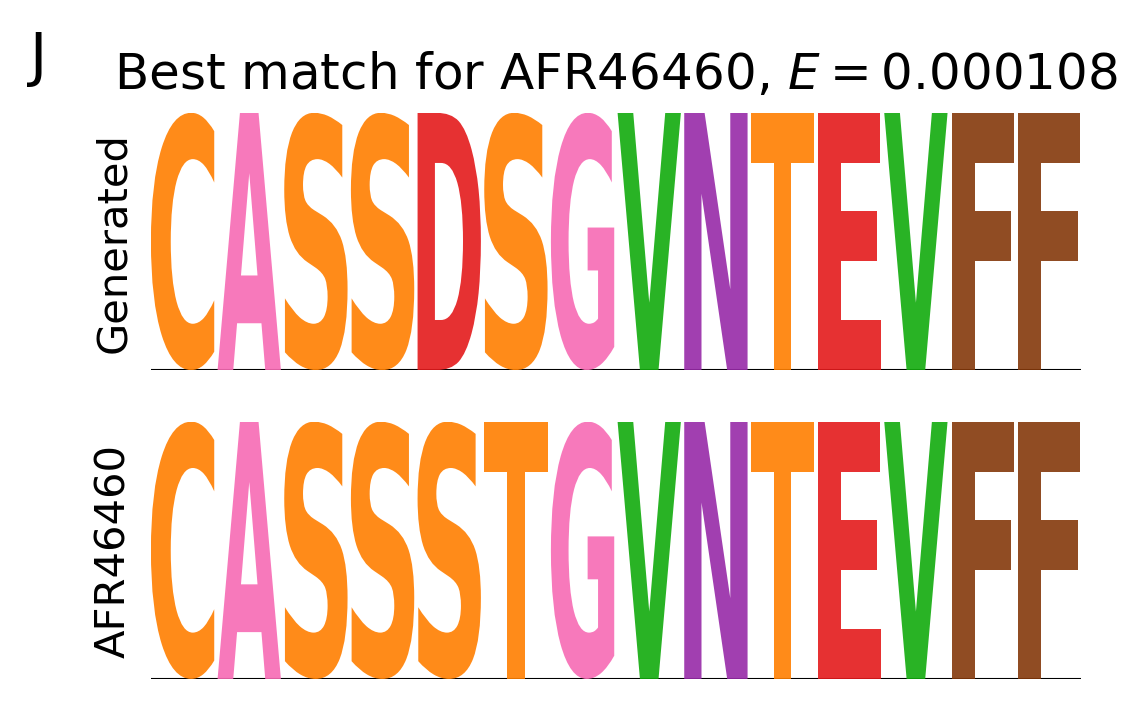

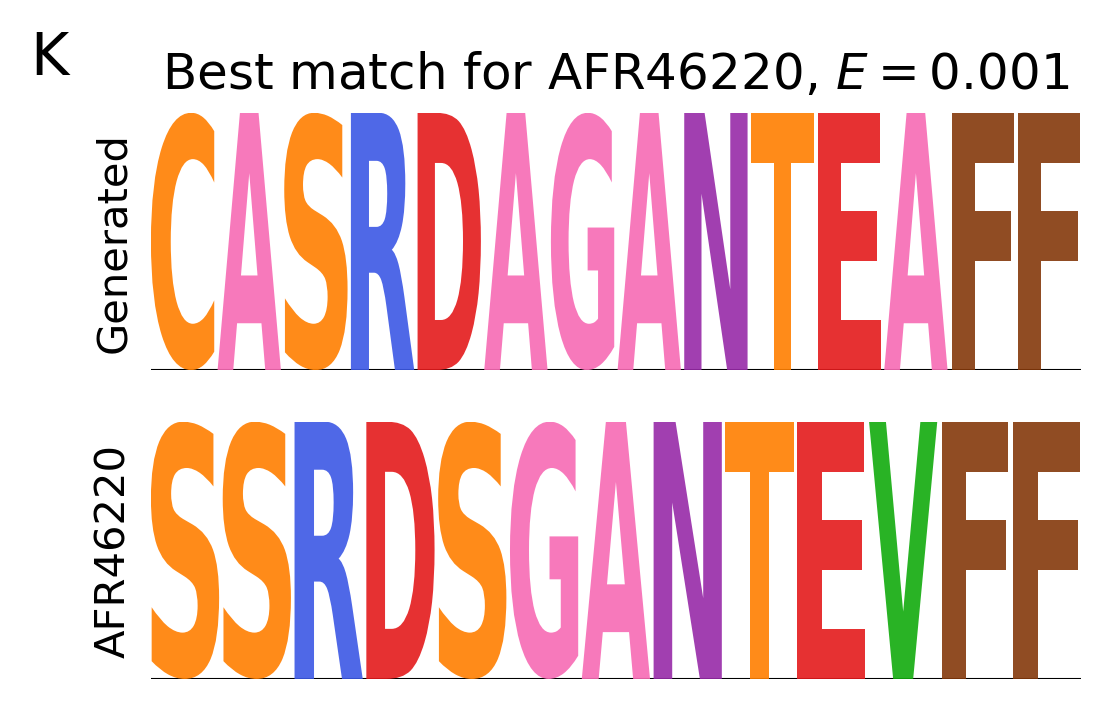

In [39]:
# Generate a paired plot for each match
import string

for i, uniq_sub_seq in enumerate(sorted(utils.dedup(list(novel_matches_df['subject_seq'])))):
    uniq_sub_seq_df = novel_matches_df.loc[novel_matches_df['subject_seq'] == uniq_sub_seq]
    # Find match with best bit score
    best_idx = np.argmax(uniq_sub_seq_df['bit_score'])
    best_match = uniq_sub_seq_df.iloc[best_idx]
    
    fig, (ax1, ax2) = plt.subplots(figsize=(4, 2.5), dpi=300, nrows=2)
    custom_metrics.motif_from_sequences(
        [best_match['query_seq']],
        ax=ax1, **logo_kwargs,
    )
    custom_metrics.motif_from_sequences(
        [best_match['subject_seq']],
        ax=ax2, **logo_kwargs,
    )
    
    ax1.text(
        -0.13, 1.15, string.ascii_uppercase[i], transform=ax1.transAxes,
        size=14#, weight='bold'
    )
    ax1.set(
        ylabel="Generated", title=f"Best match for {best_match['subject_acc']}, $E={best_match['evalue']}$",
        xticks=[], yticks=[],
    )
    ax2.set(
        ylabel=f"{best_match['subject_acc']}",
        xticks=[], yticks=[],
    )
    fig.savefig(
        os.path.join(PLOT_DIR, "per_match", f"{best_match['subject_acc']}.pdf"),
        bbox_inches='tight',
    )
    fig.show()

#### Overlap
We now explore the matches in the overlap

In [40]:
# Compare the bit scores from just the shared matches
# Marginally significant difference, engineered have higher bit scores
shared_hits = set(final_matching_known).intersection(set(starting_matching_known))
shared_start_hits = blastp_start_gp33_hits.iloc[
    np.where([s in shared_hits for s in blastp_start_gp33_hits['subject_seq']])
]
shared_final_hits = blastp_gp33_hits.iloc[
    np.where([s in shared_hits for s in blastp_gp33_hits['subject_seq']])
]

print("start", np.mean(shared_start_hits['bit_score']))
print("engineered", np.mean(shared_final_hits['bit_score']))
scipy.stats.mannwhitneyu(
    shared_final_hits['bit_score'],
    shared_start_hits['bit_score'],
)

start 26.845454545454547
engineered 27.718103448275855


MannwhitneyuResult(statistic=455.0, pvalue=0.05816778611675839)

In [41]:
shared_matches = set(final_matching_known).intersection(set(starting_matching_known))
assert not shared_matches.intersection(novel_matches)
shared_matches_df = blastp_gp33_hits.iloc[
    np.where([seq in shared_matches for seq in blastp_gp33_hits['subject_seq']])
]
shared_matches_df.shape

(116, 15)

INFO:root:Running MUSCLE for MSA in /tmp/tmpo6dhj1o1
INFO:root:Running MUSCLE for MSA in /tmp/tmpc5t6jb1s


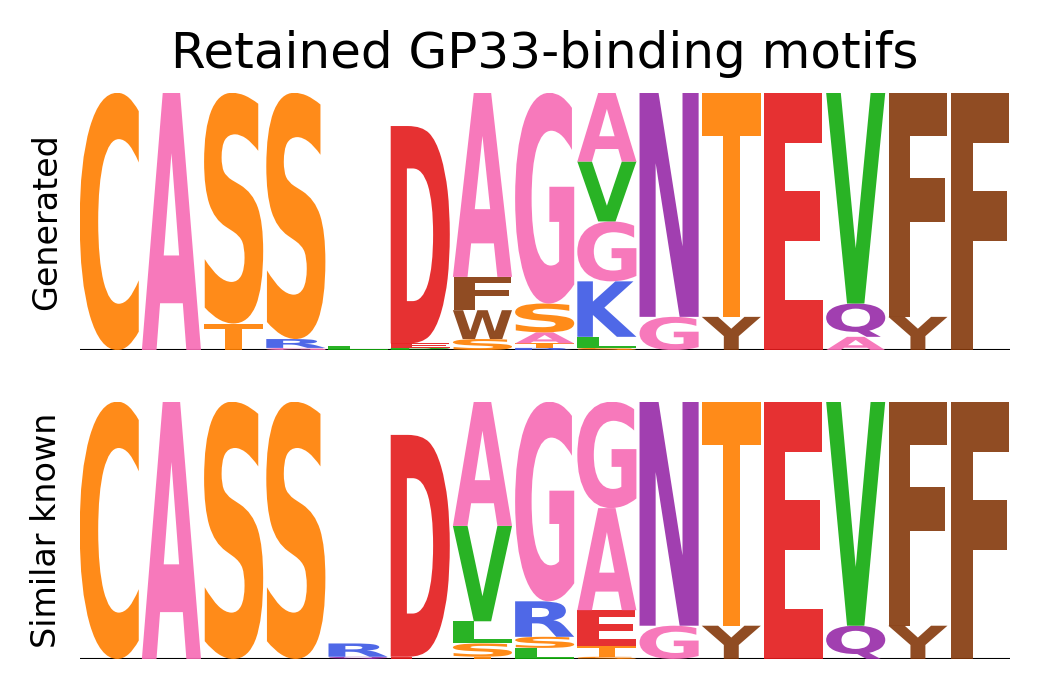

In [42]:
fig, (ax1, ax2) = plt.subplots(figsize=(4, 2.5), dpi=300, nrows=2)

custom_metrics.motif_from_sequences(
    shared_matches_df['query_seq'],
    ax=ax1, **logo_kwargs,
)[1]
ax1.set_ylabel("Generated", size=8)

custom_metrics.motif_from_sequences(
    shared_matches_df['subject_seq'],
    ax=ax2, **logo_kwargs,
)[1]
ax2.set_ylabel("Similar known", size=8)

for ax in (ax1, ax2):
    ax.set(xticks=[], yticks=[])
    
ax1.set_title("Retained GP33-binding motifs")
fig.savefig(os.path.join(PLOT_DIR, "motif_comparison_retained.pdf"), bbox_inches='tight')
fig.show()

#### Discarded

These are not kept/retained by engineering process

In [43]:
discarded_matches = set(starting_matching_known) - set(final_matching_known)
assert not discarded_matches.intersection(novel_matches)
assert not discarded_matches.intersection(shared_matches)

discarded_matches_df = blastp_start_gp33_hits.iloc[
    np.where([seq in discarded_matches for seq in blastp_start_gp33_hits['subject_seq']])
]
discarded_matches_df.shape

(36, 15)

INFO:root:Running MUSCLE for MSA in /tmp/tmp8etx2y6z


INFO:root:Running MUSCLE for MSA in /tmp/tmp4iwa_nuw


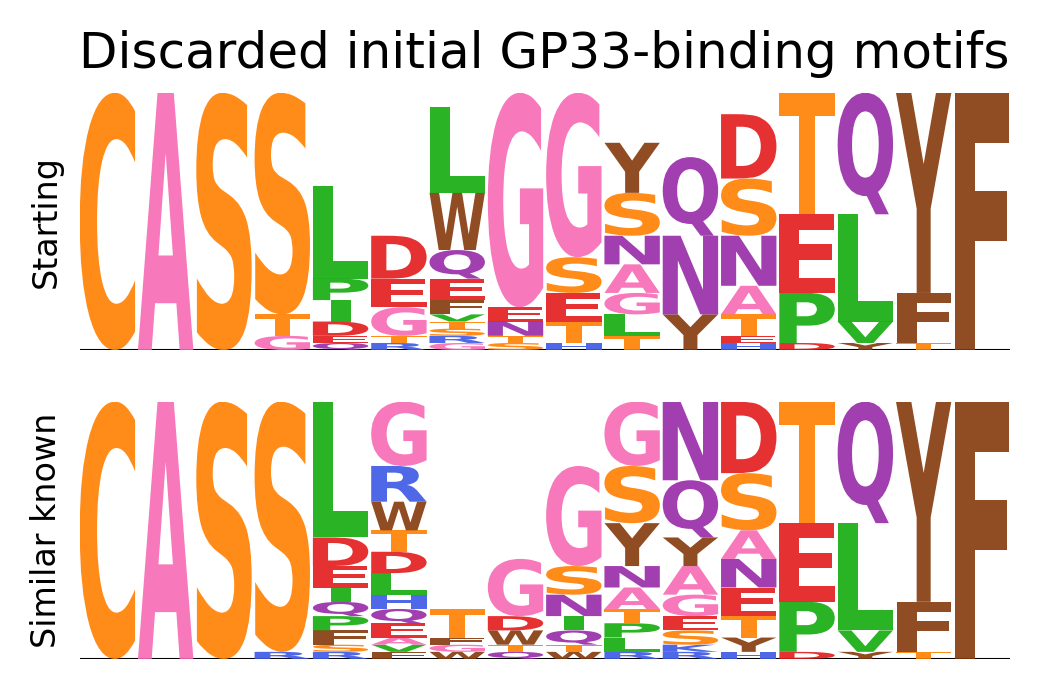

In [44]:
fig, (ax1, ax2) = plt.subplots(figsize=(4, 2.5), dpi=300, nrows=2)

custom_metrics.motif_from_sequences(
    discarded_matches_df['query_seq'],
    ax=ax1, **logo_kwargs,
)[1]
ax1.set_ylabel("Starting", size=8)

custom_metrics.motif_from_sequences(
    discarded_matches_df['subject_seq'],
    ax=ax2, **logo_kwargs,
)[1]
ax2.set_ylabel("Similar known", size=8)

for ax in (ax1, ax2):
    ax.set(xticks=[], yticks=[])
    
ax1.set_title("Discarded initial GP33-binding motifs")
fig.savefig(os.path.join(PLOT_DIR, "motif_comparison_initial_discard.pdf"), bbox_inches='tight')
fig.show()

## Where do the starting/end/matches sit in the embedding space?

In addition, we can visualize how this TCR engineering process looks in TCR-BERT's embedding space. This embedding space projects input TCRs into a continuous representation that (hopefully) captures meaningful relationships between TCRs. We see in the visualization below, that the embedding does indeed reflect some interesting patterns and relationships between the TCRs we study.

In [45]:
trbs_list = [pair[1] for pair in sequences] +\
            list(blastp_gp33_hits['query_seq']) +\
            list(blastp_gp33_hits['subject_seq'])
#             [pair[1] for pair in all_pos_pairs]
            
trbs_labels = ['start (no binding)'] * len(sequences) +\
              ['engineered w/ similarity to known binders'] * len(blastp_gp33_hits) +\
              ['similar known gp33 binders (Bunztman et al.)'] * len(blastp_gp33_hits)
#               ['LCMV gp33 binders'] * len(all_pos_pairs)

assert len(trbs_list) == len(trbs_labels)
trbs_df = pd.DataFrame({"TRB": trbs_list, "type": trbs_labels})
trbs_df

,TRB,type
0,CASSPTGENTEVFF,start (no binding)
1,CASSIEQGSYNSPLYF,start (no binding)
2,CASSQDLGGRVFF,start (no binding)
3,CASSLLGNTLYF,start (no binding)
4,CASPGDRGRAEQFF,start (no binding)
...,...,...
411,CASSDAGANTEVFF,similar known gp33 binders (Bunztman et al.)
412,CASSDAGANTEVFF,similar known gp33 binders (Bunztman et al.)
413,CASSDWGNTEVFF,similar known gp33 binders (Bunztman et al.)
414,CASSEWGGDAEQFF,similar known gp33 binders (Bunztman et al.)


In [46]:
trbs_embed = model_utils.get_transformer_embeddings(
    "wukevin/tcr-bert",
    trbs_list,
    layers=[-5],
    method='mean',
    device=3,
)
trbs_adata = ad.AnnData(trbs_embed, obs=trbs_df)
sc.pp.pca(trbs_adata, n_comps=50)
sc.pp.neighbors(trbs_adata, n_neighbors=20, knn=True, random_state=1234)
sc.tl.umap(trbs_adata, min_dist=1.5, random_state=42)
trbs_adata

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/wukevin/miniconda3/envs/tcr/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 416 × 768
    obs: 'TRB', 'type'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

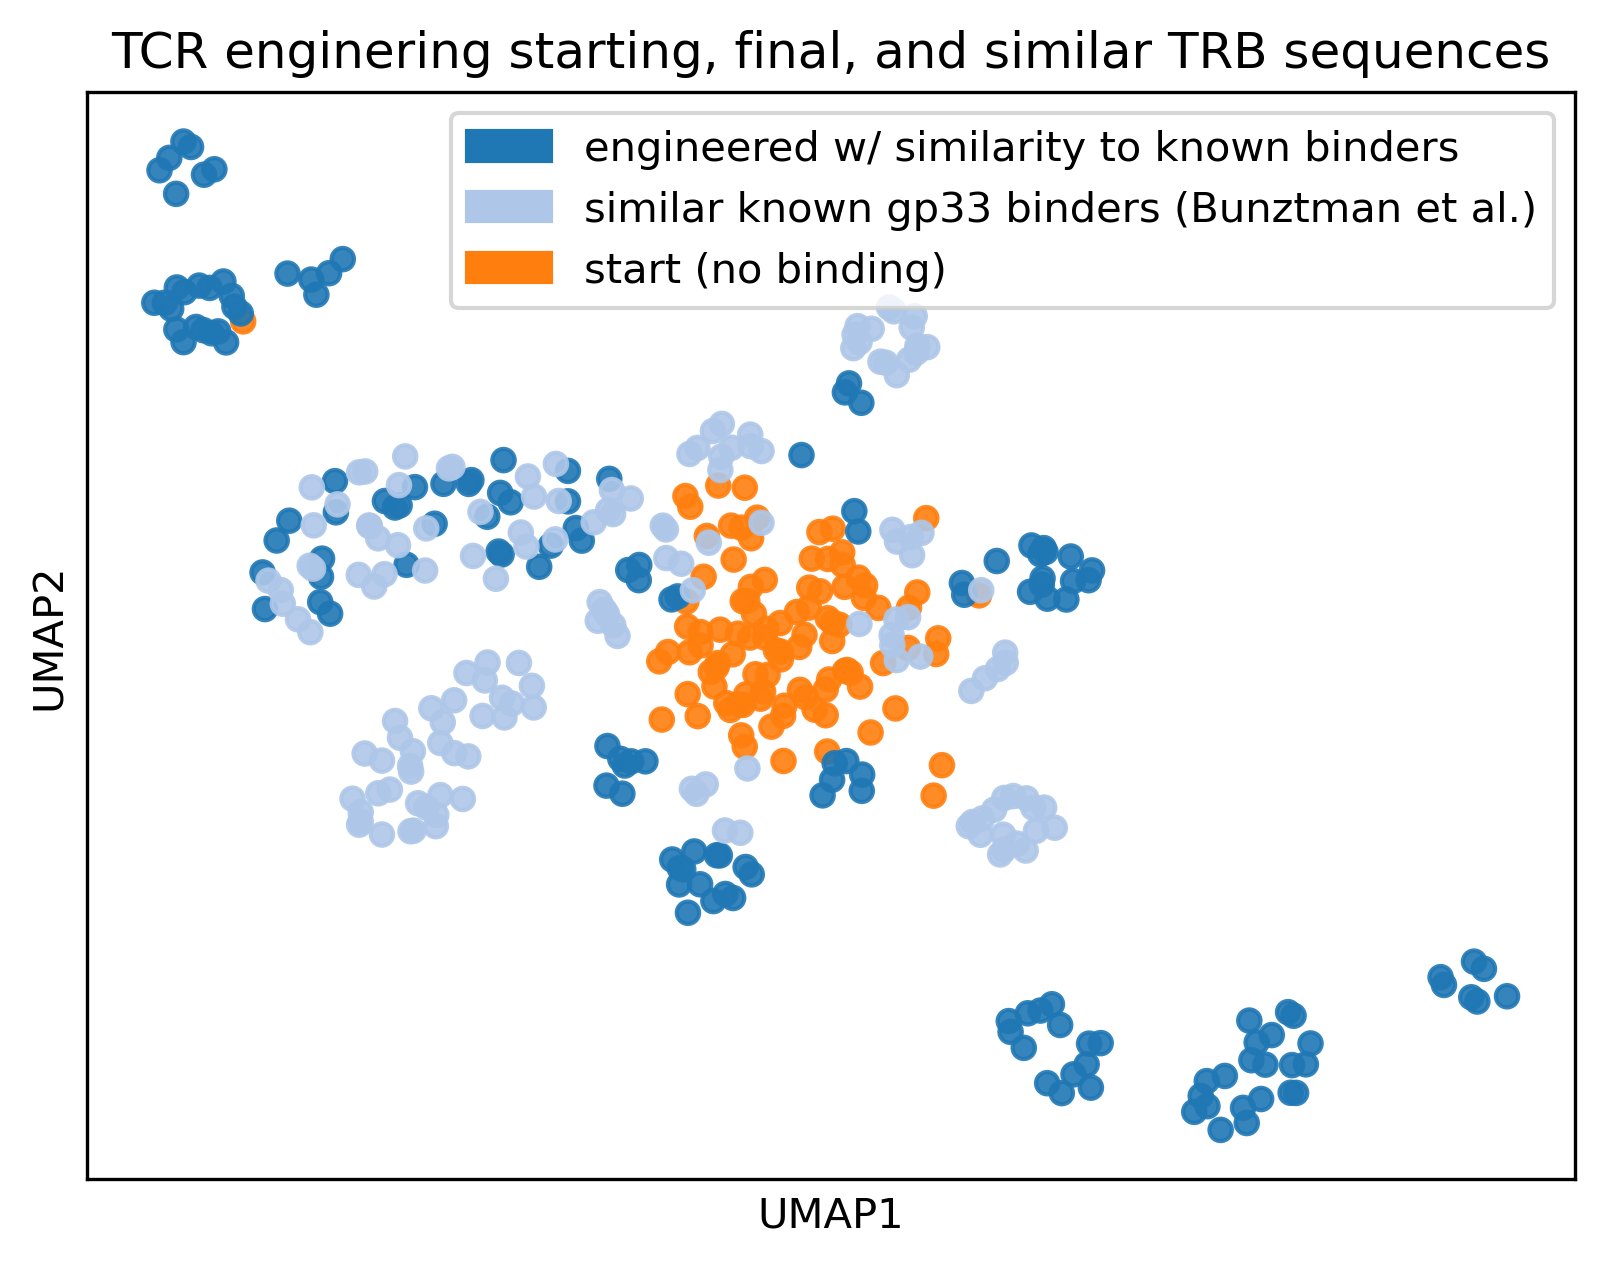

In [47]:
plot_utils.plot_anndata_rep(
    trbs_adata,
    representation='umap',
    color='type',
    direct_label=False,
    alpha=0.8,
    title="TCR enginering starting, final, and similar TRB sequences",
    fname=os.path.join(PLOT_DIR, "tcr_engineering_evolution_umap.pdf"),
).show()

## Alternative starting point

Investigate whether our method still works with a different set of starting sequences and a different random seed.

In [48]:
restricted_starting_sequences = list(zip(
    test_set_negs.iloc[:100]['TRA'],
    test_set_negs.iloc[:100]['TRB'],
))

restricted_per_iteration_pvalues, restricted_per_iteration_best_seqs = mcmc.generate_binding_sequences_skorch(
    net,
    restricted_starting_sequences,
    dl.TcrFineTuneDataset,
    {"skorch_mode": True, "idx_encode": True},
    n_iter=15,
    min_prob=0.95,
#     blacklist_aa=["D"],  # seed 420
    method="mlm",
    seed=6489,
    device=net.device.index,
)

INFO:root:Stopping generation, min predicted prob exceeds floor of 0.95


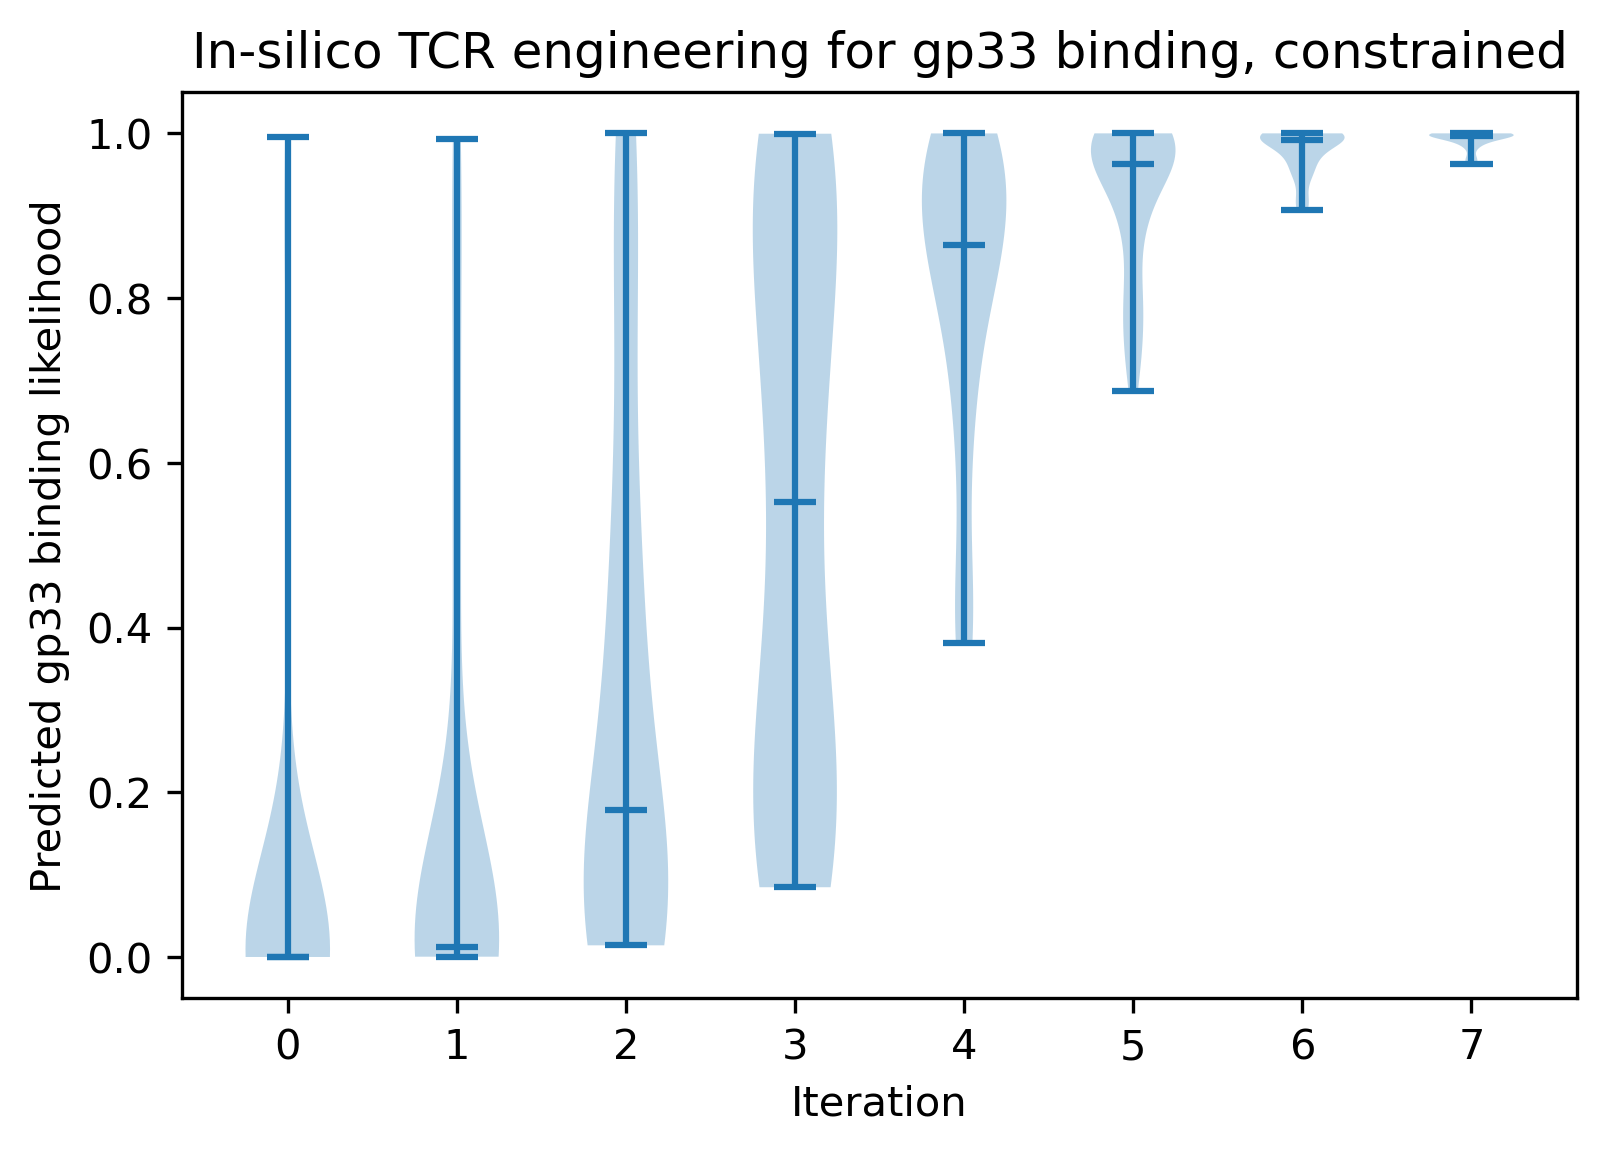

In [49]:
fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    restricted_per_iteration_pvalues.T, positions=np.arange(len(restricted_per_iteration_pvalues)),
    showmedians=True, showextrema=True
)
ax.set(
    xlabel='Iteration',
    xticks=np.arange(len(restricted_per_iteration_pvalues)),
    ylabel=f"Predicted gp33 binding likelihood",
    title="In-silico TCR engineering for gp33 binding, constrained",
)
fig.savefig(os.path.join(PLOT_DIR, "restricted_pred_gp33_affinity.pdf"), bbox_inches='tight')
fig.show()

In [50]:
restricted_blastp_hits = entrez_utils.run_blast(
    [trb for tra, trb in restricted_per_iteration_best_seqs[-1]],
    db=entrez_utils.MOUSE_TRB_BLASTDB,
    e_val=eval_cutoff,
)
restricted_blastp_hits

INFO:root:Running BLAST with E-value of 0.001 under: /tmp/tmpz6h033ap
INFO:root:Fetching addtl information for 189 matches


,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,AFR46236,80.000,15,3,0,1,15,10,24,0.000027,29.3,CASTPSLGVYAEQFF,CASSPGTGVYAEQFF,The LCMV gp33-specific memory T cell repertoir...
1,query-0,AFR46266,73.333,15,4,0,1,15,10,24,0.000114,27.7,CASTPSLGVYAEQFF,CASSPGQGLYAEQFF,The LCMV gp33-specific memory T cell repertoir...
2,query-0,CAQ77199,73.333,15,4,0,1,15,28,42,0.000384,26.9,CASTPSLGVYAEQFF,CASSLSLGVYDQQFF,Diverse hematological malignancies including h...
3,query-0,CAQ77207,73.333,15,4,0,1,15,19,33,0.000589,26.2,CASTPSLGVYAEQFF,CASSPGLGGNAEQFF,Diverse hematological malignancies including h...
4,query-0,AFV60420,73.333,15,4,0,1,15,16,30,0.000644,26.6,CASTPSLGVYAEQFF,CASSSDWGVYAEQFF,Conservation of Pathogenic TCR Homology across...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,query-48,CAA27862,80.000,15,3,0,1,15,111,125,0.000314,28.1,CASSLSLGVGAEQYF,CASSLSTGVSYEQYF,T cell receptor genes in an alloreactive CTL c...
185,query-48,AAC02882,80.000,15,3,0,1,15,3,17,0.000458,26.2,CASSLSLGVGAEQYF,CASSLSTGVSYEQYF,T cell receptor diversity in CTLs specific for...
186,query-48,P06320,80.000,15,3,0,1,15,111,125,0.000574,27.3,CASSLSLGVGAEQYF,CASSLSTGVSYEQYF,T cell receptor genes in an alloreactive CTL c...
187,query-49,ACB13520,76.923,13,3,0,1,13,12,24,0.000022,30.0,CASSDWGGWKQFF,CASSDWGGYEQYF,CD4+ T Cells Target Epitopes Residing within t...


In [51]:
restricted_blastp_gp33_hits = pd.DataFrame(
    [row for i, row in restricted_blastp_hits.iterrows() if 'gp33' in row['ms_title']]
)
restricted_blastp_gp33_hits

,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,AFR46236,80.000,15,3,0,1,15,10,24,0.000027,29.3,CASTPSLGVYAEQFF,CASSPGTGVYAEQFF,The LCMV gp33-specific memory T cell repertoir...
1,query-0,AFR46266,73.333,15,4,0,1,15,10,24,0.000114,27.7,CASTPSLGVYAEQFF,CASSPGQGLYAEQFF,The LCMV gp33-specific memory T cell repertoir...
5,query-1,AFR46246,80.000,15,3,0,1,15,10,24,0.000064,28.5,CASSPDSSYNSPLHF,CASSPGTSYNSPLYF,The LCMV gp33-specific memory T cell repertoir...
7,query-1,AFR46480,73.333,15,4,0,1,15,10,24,0.000475,26.2,CASSPDSSYNSPLHF,CASSPDRGGNSPLYF,The LCMV gp33-specific memory T cell repertoir...
10,query-2,AFR46418,78.571,14,3,0,1,14,10,23,0.000677,25.8,CASSPRDWYNEQFF,CASSSRDWGPEQFF,The LCMV gp33-specific memory T cell repertoir...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,query-44,AFR46480,73.333,15,4,0,1,15,10,24,0.000475,26.2,CASSPDSSYNSPLHF,CASSPDRGGNSPLYF,The LCMV gp33-specific memory T cell repertoir...
177,query-45,AFR46246,80.000,15,3,0,1,15,10,24,0.000064,28.5,CASSPDSSYNSPLHF,CASSPGTSYNSPLYF,The LCMV gp33-specific memory T cell repertoir...
179,query-45,AFR46480,73.333,15,4,0,1,15,10,24,0.000475,26.2,CASSPDSSYNSPLHF,CASSPDRGGNSPLYF,The LCMV gp33-specific memory T cell repertoir...
180,query-46,AFR46246,80.000,15,3,0,1,15,10,24,0.000064,28.5,CASSPDSSYNSPLHF,CASSPGTSYNSPLYF,The LCMV gp33-specific memory T cell repertoir...


In [52]:
restricted_start_blastp_hits = entrez_utils.run_blast(
    [trb for tra, trb in restricted_per_iteration_best_seqs[0]],
    db=entrez_utils.MOUSE_TRB_BLASTDB,
    e_val=eval_cutoff,
)
restricted_start_blastp_hits

INFO:root:Running BLAST with E-value of 0.001 under: /tmp/tmp1diyo_u4
INFO:root:Fetching addtl information for 393 matches


,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,ABO47663,92.857,14,1,0,1,14,23,36,0.000019,30.8,CASSSGGSQNTLYF,CASSQGGSQNTLYF,CD4+ T Cells Target Epitopes Residing within t...
1,query-0,AAC27967,92.857,14,1,0,1,14,1,14,0.000032,28.9,CASSSGGSQNTLYF,CASSRGGSQNTLYF,Spectratyping of TCR expressed by CTL-infiltra...
2,query-0,ADD98433,92.857,14,1,0,1,14,15,28,0.000038,29.3,CASSSGGSQNTLYF,CASSLGGSQNTLYF,Toxin-coupled MHC class I tetramers can specif...
3,query-0,AFV60308,92.857,14,1,0,1,14,11,24,0.000042,29.6,CASSSGGSQNTLYF,CASSLGGSQNTLYF,Conservation of Pathogenic TCR Homology across...
4,query-0,ADD98716,85.714,14,2,0,1,14,21,34,0.000093,28.1,CASSSGGSQNTLYF,CASSDGGGQNTLYF,Toxin-coupled MHC class I tetramers can specif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,query-46,ADD98762,76.923,13,3,0,1,13,21,33,0.000738,25.8,CASSDASGWEQYF,CASSDVSSYEQYF,Toxin-coupled MHC class I tetramers can specif...
389,query-46,ADD98732,76.923,13,3,0,1,13,21,33,0.000738,25.8,CASSDASGWEQYF,CASSDVSSYEQYF,Toxin-coupled MHC class I tetramers can specif...
390,query-46,ADD98254,76.923,13,3,0,1,13,21,33,0.000779,25.8,CASSDASGWEQYF,CASSDGLGYEQYF,Toxin-coupled MHC class I tetramers can specif...
391,query-48,ADD98406,84.615,13,2,0,1,13,8,20,0.000788,25.4,CASSPFRSYEQYF,CASSPGHSYEQYF,Toxin-coupled MHC class I tetramers can specif...


In [53]:
# Test whether this difference is significant
constrained_start_hit_titles_cnt = collections.Counter(restricted_start_blastp_hits['ms_title'])
constrained_start_non_gp33_count = np.sum(
    [constrained_start_hit_titles_cnt[k] for k in constrained_start_hit_titles_cnt if "gp33" not in k]
)
constrained_start_gp33_count = np.sum(
    [constrained_start_hit_titles_cnt[k] for k in constrained_start_hit_titles_cnt if "gp33" in k]
)

constrained_hit_titles_cnt = collections.Counter(restricted_blastp_hits['ms_title'])
constrained_final_non_gp33_count = np.sum(
    [constrained_hit_titles_cnt[k] for k in constrained_hit_titles_cnt if 'gp33' not in k]
)
constrained_final_gp33_count = np.sum(
    [constrained_hit_titles_cnt[k] for k in constrained_hit_titles_cnt if 'gp33' in k]
)

constrained_chisquare_count_input = np.array(
    [
        [constrained_start_non_gp33_count, constrained_start_gp33_count],
        [constrained_final_non_gp33_count, constrained_final_gp33_count],
    ]
)
print(constrained_chisquare_count_input)
scipy.stats.fisher_exact(constrained_chisquare_count_input)

[[324  69]
 [128  61]]


(2.2377717391304346, 0.00011698588882379555)

INFO:root:Running MUSCLE for MSA in /tmp/tmpq5scovr9
INFO:root:Running MUSCLE for MSA in /tmp/tmpleqezzhj


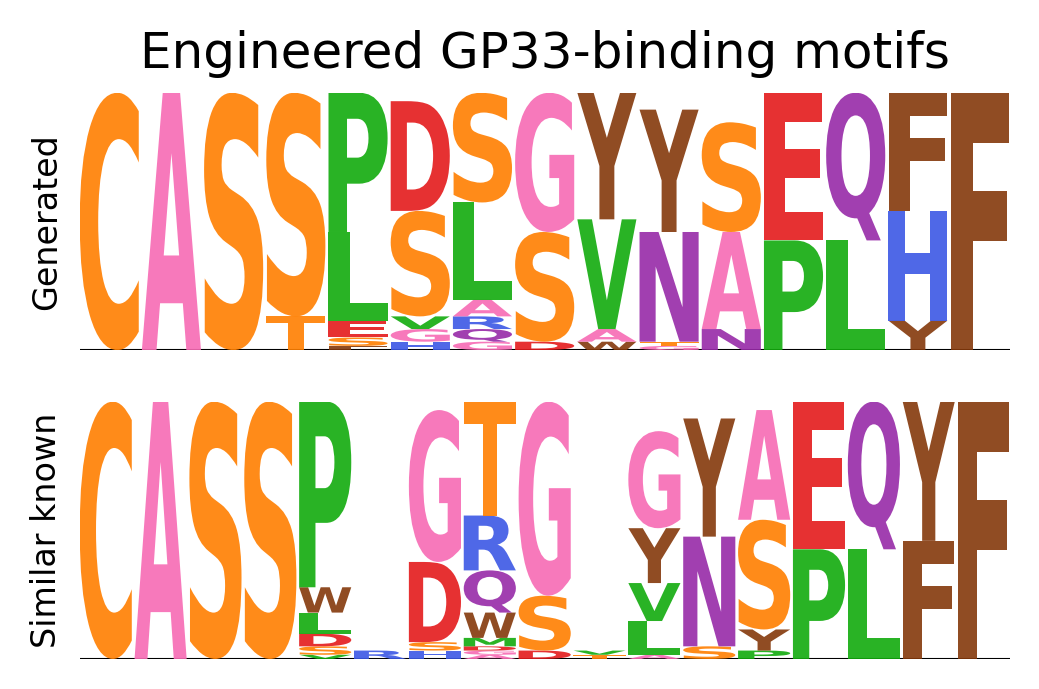

In [54]:
fig, (ax1, ax2) = plt.subplots(figsize=(4, 2.5), dpi=300, nrows=2)

custom_metrics.motif_from_sequences(
    restricted_blastp_gp33_hits['query_seq'],
    ax=ax1, **logo_kwargs,
)[1]
ax1.set_ylabel("Generated", size=8)

custom_metrics.motif_from_sequences(
    restricted_blastp_gp33_hits['subject_seq'],
    ax=ax2, **logo_kwargs,
)[1]
ax2.set_ylabel("Similar known", size=8)

for ax in (ax1, ax2):
    ax.set(xticks=[], yticks=[])
    
ax1.set_title("Engineered GP33-binding motifs")
fig.savefig(os.path.join(PLOT_DIR, "restricted_motif_comparison_generated.pdf"), bbox_inches='tight')
fig.show()